# Amazon Apparel Recommendation (Content-Based)

### 1. Data Source:-

https://www.kaggle.com/datasets/ajaysh/women-apparel-recommendation-engine-amazoncom#tops_fashion.json

### 2. Data Overview:-

In [5]:
#importing all the neccessary packages
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected = True)
warnings.filterwarnings("ignore")

In [3]:
# we have the data in json format which consists of all the information.
# loading the data using pandas.
data = pd.read_json("tops_fashion.json")

In [4]:
print(f"Number of data points {data.shape[0]}")
print(f"Number of features/variables {data.shape[1]}")

Number of data points 183138
Number of features/variables 19


In [5]:
# we have 183138 products each having 19 features.
# features -->
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

out of these 19 features we will be using below 6 features only:-
1. asin  (Amazon standard identification number)
2. brand (brand to which the product belongs)
3. color (color information of the apparel, it can contain many colors as a value, ex:- blue and green stripes)
4. product_type_name (type of the apparel, ex:- top/jeans)
5. medim_image_url (url of the image)
6. title (title of the product)
7. formatted_price (price of the product)

In [6]:
data = data[["asin", "brand", "color", "product_type_name", "medium_image_url", "title", "formatted_price"]]

In [7]:
print(f"Number of data points {data.shape[0]}")
print(f"Number of features/variables {data.shape[1]}")

Number of data points 183138
Number of features/variables 7


In [8]:
data.head()

asin         brand              color product_type_name  \
0  B016I2TS4W         FNC7C               None             SHIRT   
1  B01N49AI08  FIG Clothing               None             SHIRT   
2  B01JDPCOHO  FIG Clothing               None             SHIRT   
3  B01N19U5H5       Focal18               None             SHIRT   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone             SHIRT   

                                    medium_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

## 3. Missing data for various features

### basic stats for the feature: product_type_name

In [9]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


1. We have total 72 unique types of products.
2. No missing values for this feature.
3. 167794 / 183138 = 91.62% of the products are Shirts.

In [10]:
# names of unique product types ->
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [11]:
# 10 most frequent types of products ->
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

### basic stats for the feature: brand

In [12]:
print(data['brand'].describe())

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


1. For brand we have (183138 - 182987) = 151 missing values.
2. We have 10577 unique brands.

In [13]:
# 10 most frequent brands ->
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

### basic stats for the feature: color

In [14]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


1. We have (183138 - 64956) = 118182 missing values. It is approx 64.53% of the data.
2. 7.2% of products are in black color.
3. We have 7380 unique colors.

In [15]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

### basis stats for feature: formatted_price

In [16]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


1. We have (183138 - 28395) = 154743 missing values. It is approx 84.5% of data.
2. 3.32% of products containing prices, have $19.99 as price.
3. We have 3135 unique prices.

In [17]:
formatted_price_count = Counter(list(data['formatted_price']))
formatted_price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

### basis stats for feature: title

In [18]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


1. All of the products have a title.
2. Titles are fairly descriptive of what the product is.
3. We have 175985 unique titles.

In [19]:
title_count = Counter(list(data['title']))
title_count.most_common(10)

[('Nakoda Cotton Self Print Straight Kurti For Women', 77),
 ("Q-rious Women's Racerback Cotton Lycra Camsioles", 56),
 ('FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops', 47),
 ('Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes', 44),
 ("ELINA FASHION Women's Indo-Western Tunic Top Cotton Kurti", 43),
 ('Victoria Scoop Neck Front Lace Floral High-Low Top in 4 Sizes', 40),
 ("Cenizas Women's Indian Tunic Top Cotton Kurti", 39),
 ('Indistar Womens Premium Cotton Half Sleeves Printed T-Shirts/Tops (Pack of 3)',
  37),
 ("Rajnandini Women's Cotton Printed Kurti", 35),
 ('Long Sleeve Mock Neck Top', 32)]

In [20]:
data.to_pickle("pickles/180k_apparel_data")

We save data files at every major step in our processing in "pickle" files.

#### 1. Considering product which have the price information:-

In [21]:
data = data.loc[~data["formatted_price"].isnull()]
print(f"Number of data points after eliminating price=Null: {data.shape[0]}")

Number of data points after eliminating price=Null: 28395


#### 2. Eliminating products which don't contain color:-

In [22]:
data = data.loc[~data["color"].isnull()]
print(f"Number of data points after eliminating color=Null: {data.shape[0]}")

Number of data points after eliminating color=Null: 28385


#### We brough down the number of data points from 183k to 28k.

In [23]:
# saving data into a pickle file.
data.to_pickle("pickles/28k_apparel_data")

## 4. Removing Duplicate Items:-

In [25]:
# reading data from pickle file from previous stage
data = pd.read_pickle("pickles/28k_apparel_data")
# no of products having duplicate title -->
print(sum(data.duplicated("title")))

2325


We have 2325 products having same title.

In [29]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
21  B014ICEDNA                        FNC7C             Purple   

   product_type_name                                   medium_image_url  \
4              SHIRT  https://images-na.ssl-images-amazon.com/images...   
6              SHIRT  https://images-na.ssl-images-amazon.com/images...   
11             SHIRT  https://images-na.ssl-images-amazon.com/images...   
15             SHIRT  https://images-na.ssl-images-amazon.com/images...   
21             SHIRT  https://images-na.ssl-images-amazon.com/images...   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
11             Ladies Cotton Tank 2x1 Ribbed Tank Top          $11.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
21  Supernatural Chibis Sam Dean And Castiel Short...           $7.50

In [32]:
# Removing all products with very few words in title 
data = data[data['title'].apply(lambda x: len(x.split()) > 4)]
print(f"After removal of products with short title we have {data.shape[0]} data points.")

After removal of products with short title we have 27949 data points.


In [34]:
# Sorting the whole data based on title (natural order)
data.sort_values('title',inplace=True)
data

asin                  brand                 color  \
118987  B008D30AGK  Out+of+Print+Clothing          Multicolored   
78827   B003IDE8XQ      Maggie's Organics                  Grey   
109599  B00KI3VDXM            Crazy4Bling                Purple   
40451   B073SKNQHD   The Workout Princess  Premium Heather Gray   
12050   B06WRW8RQ1                     AJ                 Black   
...            ...                    ...                   ...   
151570  B00WPJG35K               xiaoming                 White   
75995   B00X5LYO9Y               xiaoming           Red Anchors   
81461   B01DDSDLNS               xiaoming                 White   
133820  B010RV33VE               xiaoming                  Pink   
61973   B06Y1KZ2WB                 Éclair            Black/Pink   

       product_type_name                                   medium_image_url  \
118987             SHIRT  https://images-na.ssl-images-amazon.com/images...   
78827               HOME  https://images-na.ssl-images-amazon.com/images...   
109599             SHIRT  https://images-na.ssl-images-amazon.com/images...   
40451              SHIRT  https://images-na.ssl-images-amazon.com/images...   
12050              SHIRT  https://images-na.ssl-images-amazon.com/images...   
...                  ...                                                ...   
151570             SHIRT  https://images-na.ssl-images-amazon.com/images...   
75995              SHIRT  https://images-na.ssl-images-amazon.com/images...   
81461              SHIRT  https://images-na.ssl-images-amazon.com/images...   
133820             SHIRT  https://images-na.ssl-images-amazon.com/images...   
61973              SHIRT  https://images-na.ssl-images-amazon.com/images...   

                                                    title formatted_price  
118987  "1984" Retro Book Cover Women's SLim Fit T-Shi...           $7.51  
78827          "Camisoles Grey - Medium Fair Labor, 1 pc"          $18.99  
109599  "I Wanna Be Adored" Long Sleeve Top with Shred...          $39.99  
40451   "I Workout To Burn off The Crazy", Tri Blend T...          $24.99  
12050   "Life is a Journey" Self-Help DIY T-Shirt (Wom...           $9.38  
...                                                   ...             ...  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  

[27949 rows x 7 columns]

### Some examples of duplicate titles that differ only in last few words

#### Removing these duplicates:-

In [42]:
indices = []
for i, row in data.iterrows():
    indices.append(i)

In [48]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
no_of_datapts = data.shape[0]
while i < no_of_datapts and j < no_of_datapts:
    prev_i = i
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()
    # search for the similar products sequentially 
    j = i + 1
    while j < no_of_datapts:
        # store the list of words of jth string in b
        b = data['title'].loc[indices[j]].split()
        # store the maximum length of two strings
        length = max(len(a), len(b))
        count  = 0 # To store the number of matching words in both the strings.
        
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them.
        if (length - count) > 2:
            stage1_dedupe_asins.append(data['asin'].loc[indices[i]])
            if j == no_of_datapts-1: stage1_dedupe_asins.append(data['asin'].loc[indices[j]])
            i = j
            break
        else:
            j += 1
    if prev_i == i:
        break

In [49]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
print(f"No. of data points: {data.shape[0]}")

No. of data points: 17587


In [50]:
data.to_pickle('pickles/17k_apparel_data')

#### Removing these duplicates:-

In [51]:
indices = []
for i, row in data.iterrows():
    indices.append(i)

In [52]:
stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    
    for j in indices:        
        b = data['title'].loc[j].split()
        length = max(len(a),len(b))        
        # count is used to store the number of words that are matched in both strings
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1
        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [54]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
print(f"No of data points after deduplication stage 2: {data.shape[0]}")

No of data points after deduplication stage 2: 16466


In [55]:
# Saving data into pickle file
data.to_pickle('pickles/16k_apparel_data')

# 5. Text Preprocessing 

In [3]:
data = pd.read_pickle("pickles/16k_apparel_data")

In [7]:
# we use the list of stopwords that are downloaded from nltk lib.
stop_words = set(stopwords.words("english"))
print(f"list of stopwords: {stop_words}")

list of stopwords: {"should've", 'his', 'in', "you'd", 'from', "needn't", 'himself', 'does', 'all', 'into', 'wasn', 'because', 'haven', 'had', 'hadn', "shouldn't", "couldn't", 'isn', "she's", 'above', 'wouldn', "didn't", 't', 'we', "doesn't", 'out', 'they', 'same', 'whom', 'aren', "hadn't", 'am', 'against', 'been', 'any', 'too', 'now', 'yourself', 'it', 'other', 'both', "it's", 'll', 'on', 'd', 'ourselves', 'for', 'he', 'him', 'here', 'ours', 'mustn', "you've", 'during', "mightn't", 'won', 'while', 'not', 'to', "you're", 'needn', 've', 'between', 'your', 'her', 'at', 'don', 'only', 'own', 'no', 'weren', 'but', 'hasn', 'if', "shan't", 'down', 'y', 'about', 'until', 'over', "wouldn't", 'will', 'some', "aren't", 'each', 'what', 'you', 'that', 'having', "you'll", 'shouldn', 'be', 'which', 'mightn', 'and', 'should', 'hers', 'me', 'was', 'few', 'most', "mustn't", 'who', 'them', 'these', 'very', 'did', 're', 'i', 'just', 'herself', 'than', 'there', 'an', 'so', 'or', 'nor', 'themselves', 'have

In [8]:
def nlp_preprocessing(text, index, column):
    if type(text) is not int:
        string = ""
        for words in text.split():
            # removing special characters, e.g. !@#$%^&...
            word = ("".join(c for c in words if c.isalnum()))
            # converting all letters to lower case
            word = word.lower()
            # removing stopwords
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [11]:
start_time = time.perf_counter()
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
end_time = time.perf_counter()
print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 3.056740300031379 seconds


In [12]:
data.head()

asin                  brand                 color  \
118987  B008D30AGK  Out+of+Print+Clothing          Multicolored   
78827   B003IDE8XQ      Maggie's Organics                  Grey   
109599  B00KI3VDXM            Crazy4Bling                Purple   
40451   B073SKNQHD   The Workout Princess  Premium Heather Gray   
12050   B06WRW8RQ1                     AJ                 Black   

       product_type_name                                   medium_image_url  \
118987             SHIRT  https://images-na.ssl-images-amazon.com/images...   
78827               HOME  https://images-na.ssl-images-amazon.com/images...   
109599             SHIRT  https://images-na.ssl-images-amazon.com/images...   
40451              SHIRT  https://images-na.ssl-images-amazon.com/images...   
12050              SHIRT  https://images-na.ssl-images-amazon.com/images...   

                                                    title formatted_price  
118987  1984 retro book cover womens slim fit tshirt p...           $7.51  
78827              camisoles grey medium fair labor 1 pc           $18.99  
109599  wanna adored long sleeve top shredded shoulder...          $39.99  
40451   workout burn crazy tri blend tank top funny wo...          $24.99  
12050   life journey selfhelp diy tshirt womensilverfe...           $9.38

In [13]:
data.to_pickle("pickles/16k_apparel_data_preprocessed")

# 6. Text based Product similarity

In [9]:
data = pd.read_pickle('pickles/16k_apparel_data_preprocessed')
data.head()

asin                  brand                 color  \
118987  B008D30AGK  Out+of+Print+Clothing          Multicolored   
78827   B003IDE8XQ      Maggie's Organics                  Grey   
109599  B00KI3VDXM            Crazy4Bling                Purple   
40451   B073SKNQHD   The Workout Princess  Premium Heather Gray   
12050   B06WRW8RQ1                     AJ                 Black   

       product_type_name                                   medium_image_url  \
118987             SHIRT  https://images-na.ssl-images-amazon.com/images...   
78827               HOME  https://images-na.ssl-images-amazon.com/images...   
109599             SHIRT  https://images-na.ssl-images-amazon.com/images...   
40451              SHIRT  https://images-na.ssl-images-amazon.com/images...   
12050              SHIRT  https://images-na.ssl-images-amazon.com/images...   

                                                    title formatted_price  
118987  1984 retro book cover womens slim fit tshirt p...           $7.51  
78827              camisoles grey medium fair labor 1 pc           $18.99  
109599  wanna adored long sleeve top shredded shoulder...          $39.99  
40451   workout burn crazy tri blend tank top funny wo...          $24.99  
12050   life journey selfhelp diy tshirt womensilverfe...           $9.38

### Utility Functions

In [64]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
import re
from collections import Counter

def display_img(url, ax, fig):
    # We get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # We will display it in notebook 
    ax.imshow(img)

# Plotting code to understand the decision  
def plot_heatmap(keys, values, labels, url, text):
    # keys: list of words of recommended title
    # values: len(values) ==  len(keys), values(i) represents the occurrence of the word keys(i)
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
    # if model == 'bag of words': labels(i) = values(i)
    # if model == 'tfidf weighted bag of words': labels(i) = tfidf(keys(i))
    # if model == 'idf weighted bag of words': labels(i) = idf(keys(i))
    # url : apparel's url
    # We will divide the whole figure into two parts
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[4, 1]) 
    fig = plt.figure(figsize=(25, 3))
    
    # 1st, plotting heat map that represents the count of commonly occurred words in title2
    ax = plt.subplot(gs[0])
    # It displays a cell in white color if the word is intersection (list of words of title1 and list of words of title2), in black if not
    sns.heatmap(np.array([values]), annot=np.array([labels]), ax=ax)
    ax.set_xticklabels(keys) # Set the axis labels as the words of title
    ax.set_title(text) # Apparel title
    
    # 2nd, plotting image of the apparel
    ax = plt.subplot(gs[1])
    # We don't want any grid lines for image and no labels on x-axis and y-axis
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # We call display_img with parameter url
    display_img(url, ax, fig)
    
    # Displays combined figure (heat map and image together)
    plt.show()

def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word: count}
    # vec2 : recommended apparels's vector, it is of a dict type {word: count}
    # url : apparel's image url
    # text: title of recommended apparel (used to keep title of image)
    # model, it can be any of the models, 
    # 1. bag_of_words
    # 2. tfidf
    # 3. idf
    # We find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys())
    # We set the values of non-intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i] = 0
    # For labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    # If ith word in intersection (list of words of title1 and list of words of title2): values(i) = count of that word in title2 else values(i) = 0 
    values = [vec2[x] for x in vec2.keys()]    
    # Labels: len(labels) == len(keys), the values of labels depends on the model we are using
    # if model == 'bag of words': labels(i) = values(i)
    # if model == 'tfidf weighted bag of words': labels(i) = tfidf(keys(i))
    # if model == 'idf weighted bag of words': labels(i) = idf(keys(i))
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys, values, labels, url, text)

# This function gets a list of words along with the frequency of each word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' 
    # this will also give the same result
    return Counter(words) # Counter counts the occurrence of each word in list, 
    # it returns dict type object {word1: count}

def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)
    # vector2 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# [6.1] Bag of Words (BoW) on product titles

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16466, 12689)

In [70]:
def bag_of_words_model(docID, num_results):
    # doc_id: apparel's id in given corpus
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is euclidean.
    pairwise_dist = pairwise_distances(title_features, title_features[docID])
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #products_distances will store the smallest distances
    products_distances = np.sort(pairwise_dist.flatten())[0:num_results]
    #data frame indices of the smallest distaces
    df_indices = list(data.index[indices])
    for i in range(0, len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], "bag_of_words")
        print(f"Asin : {data['asin'].loc[df_indices[i]]}")
        print(f"Brand : {data['brand'].loc[df_indices[i]]}")
        print(f"Title : {data['title'].loc[df_indices[i]]}")
        print(f"Euclidian similarity with the query image : {products_distances[i]}")
        print("*"*120)
    print("-"*120)
    print(f"Average euclidean distance = {sum(products_distances) / len(products_distances)}")

Getting the similar items for document id and number of items


Asin : B01N2W9P7A
Brand : IGotCollared Pronounced I Got Collared
Title : 3pack black light pink white womens dickey collars usabased igotcollared aka dicky collar 
Euclidian similarity with the query image : 0.0
************************************************************************************************************************


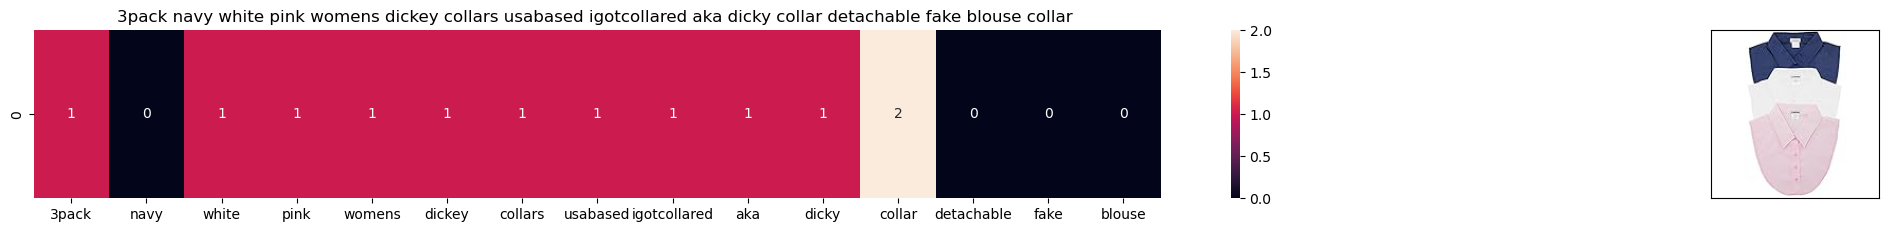

Asin : B01MZ24OV9
Brand : IGotCollared Pronounced I Got Collared
Title : 3pack navy white pink womens dickey collars usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidian similarity with the query image : 2.6457513110645907
************************************************************************************************************************


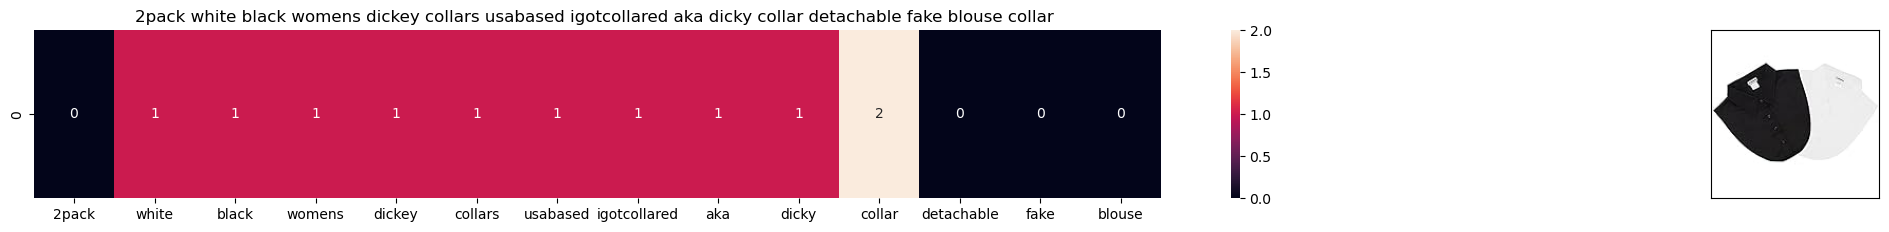

Asin : B01N4GCBUM
Brand : IGotCollared Pronounced I Got Collared
Title : 2pack white black womens dickey collars usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidian similarity with the query image : 2.8284271247461903
************************************************************************************************************************


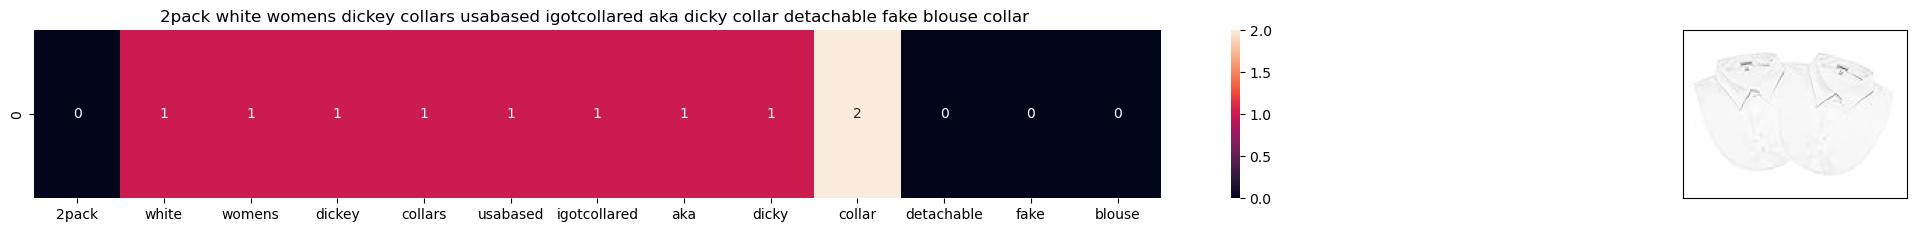

Asin : B01N9JYI2N
Brand : IGotCollared Pronounced I Got Collared
Title : 2pack white womens dickey collars usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidian similarity with the query image : 3.0
************************************************************************************************************************


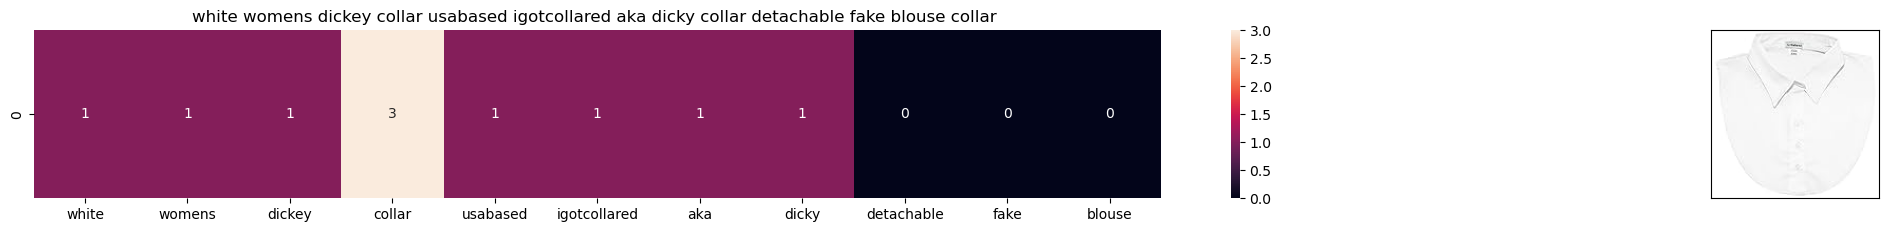

Asin : B01NCM39R4
Brand : IGotCollared
Title : white womens dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidian similarity with the query image : 3.4641016151377544
************************************************************************************************************************


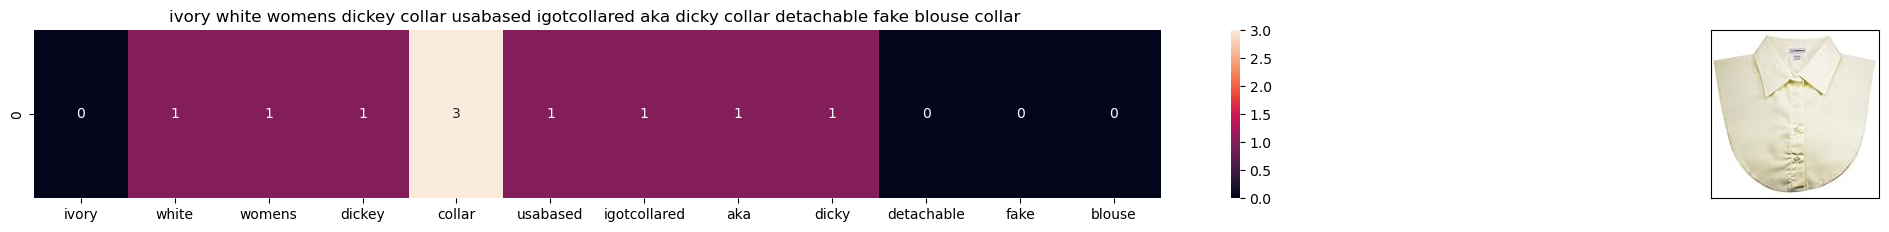

Asin : B01MRUN3UC
Brand : IGotCollared
Title : ivory white womens dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidian similarity with the query image : 3.605551275463989
************************************************************************************************************************


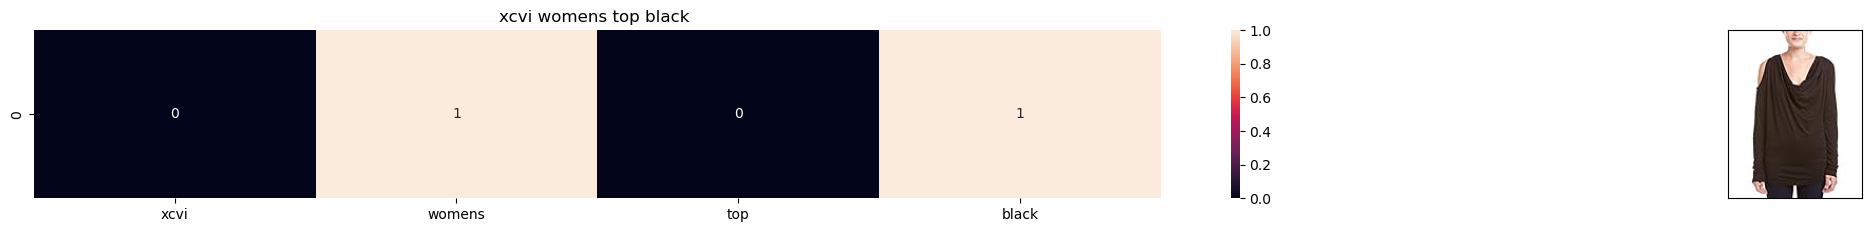

Asin : B01NB9C9Z4
Brand : XCVI
Title : xcvi womens top black 
Euclidian similarity with the query image : 3.605551275463989
************************************************************************************************************************


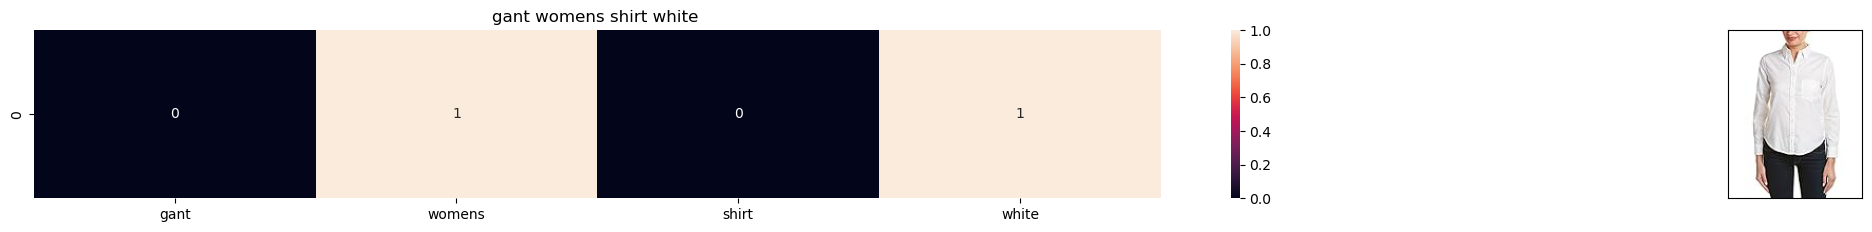

Asin : B01N80ZGZX
Brand : GANT
Title : gant womens shirt white 
Euclidian similarity with the query image : 3.605551275463989
************************************************************************************************************************


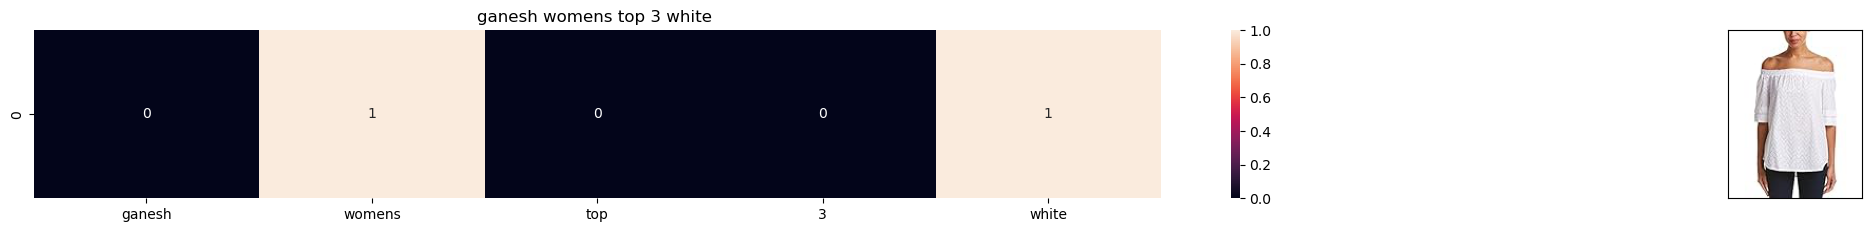

Asin : B071VY45DD
Brand : Ganesh
Title : ganesh womens top 3 white 
Euclidian similarity with the query image : 3.605551275463989
************************************************************************************************************************


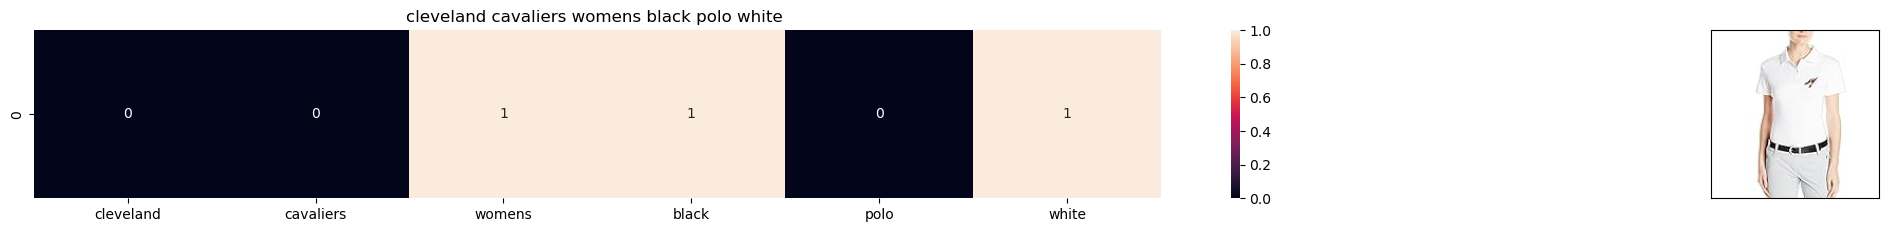

Asin : B01G1LXTDQ
Brand : zhoujie
Title : cleveland cavaliers womens black polo white 
Euclidian similarity with the query image : 3.605551275463989
************************************************************************************************************************


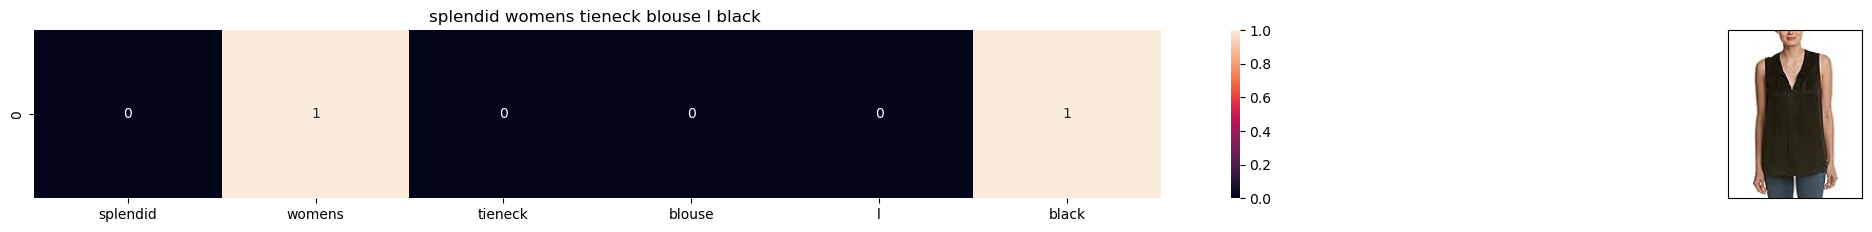

Asin : B0716F4X2L
Brand : Splendid
Title : splendid womens tieneck blouse l black 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


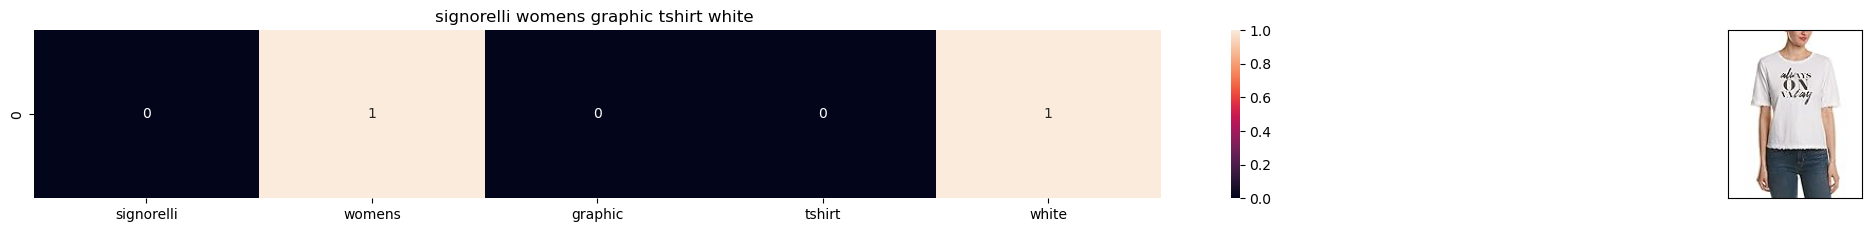

Asin : B07119RDQ1
Brand : Signorelli
Title : signorelli womens graphic tshirt white 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


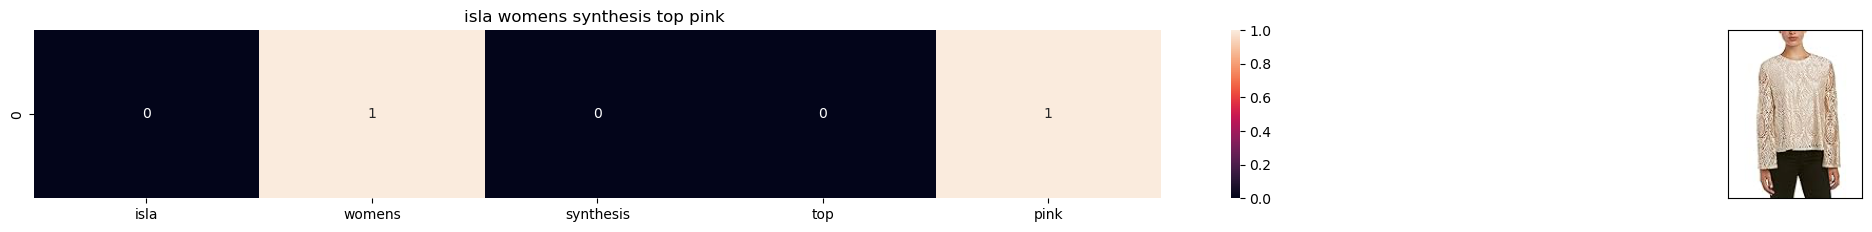

Asin : B074MGBYCD
Brand : Isla
Title : isla womens synthesis top pink 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


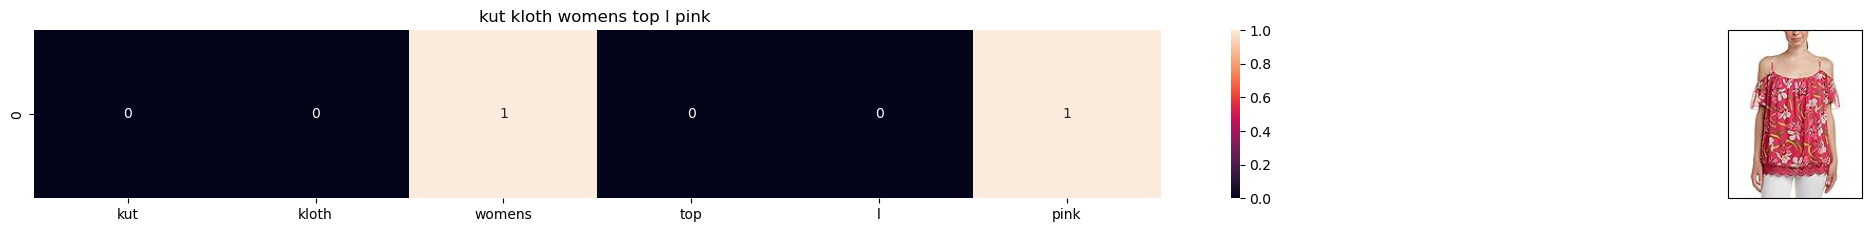

Asin : B07485W6NF
Brand : KUT from the Kloth
Title : kut kloth womens top l pink 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


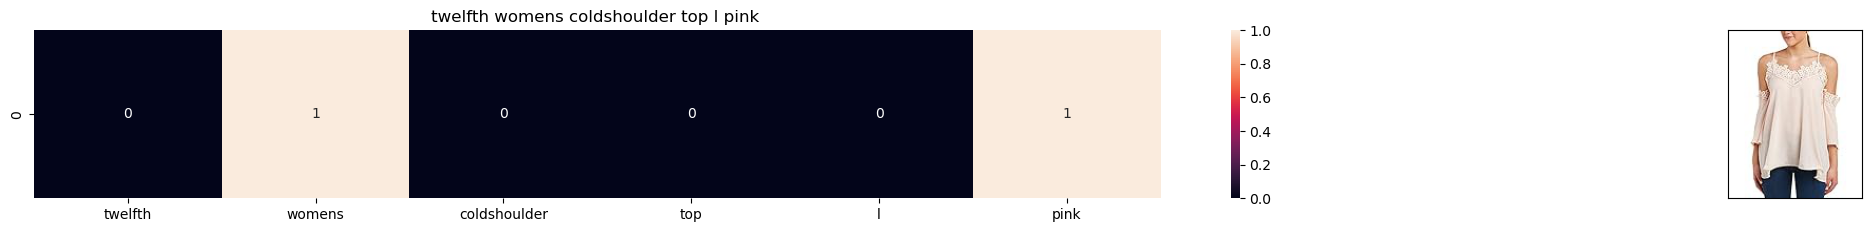

Asin : B074F49Q1C
Brand : On Twelfth
Title : twelfth womens coldshoulder top l pink 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


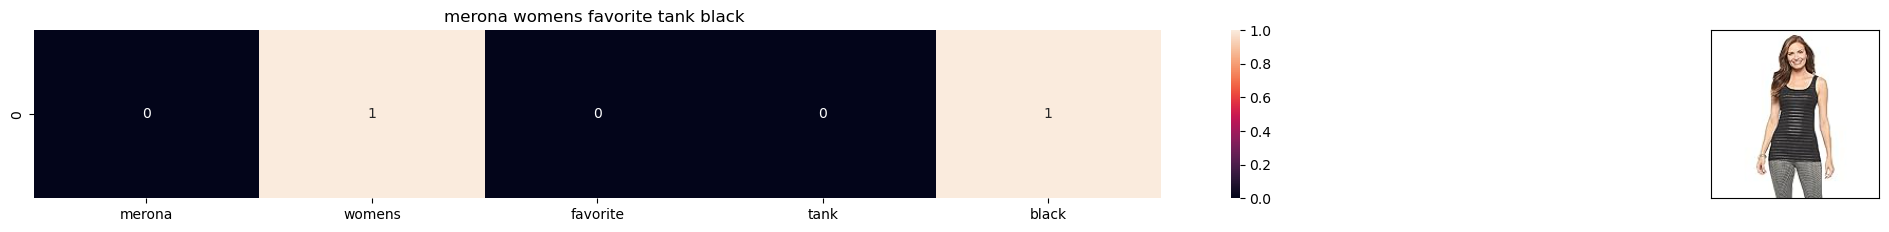

Asin : B01KBGZE4Y
Brand : Merona
Title : merona womens favorite tank black 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


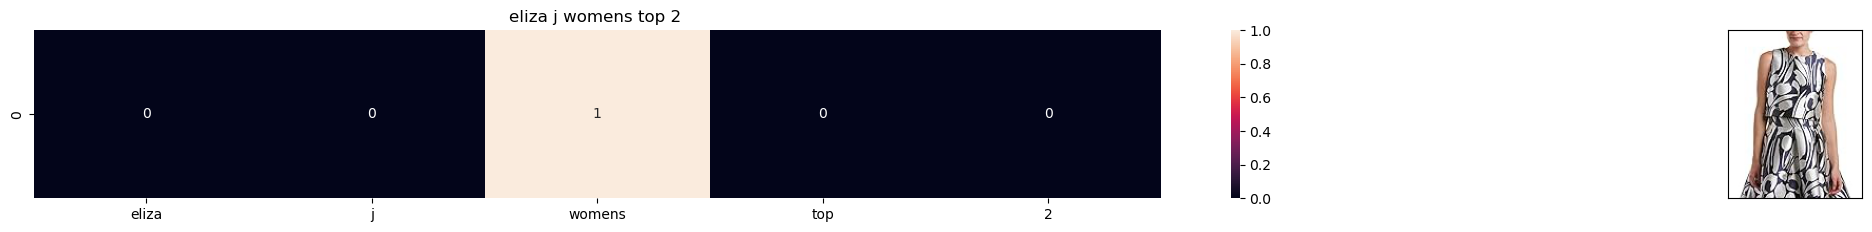

Asin : B01N0645HW
Brand : Eliza J
Title : eliza j womens top 2 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


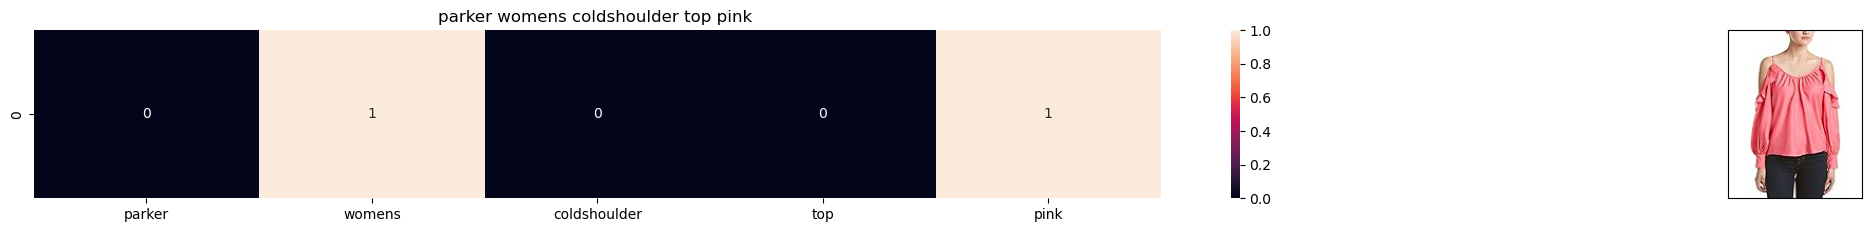

Asin : B01MZ735IP
Brand : Parker
Title : parker womens coldshoulder top pink 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


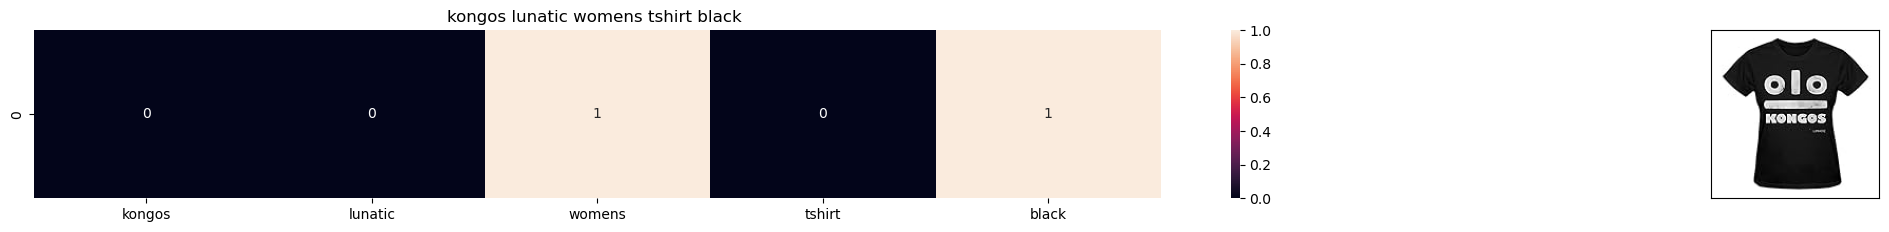

Asin : B01IXZLJIA
Brand : Moonflow
Title : kongos lunatic womens tshirt black 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************


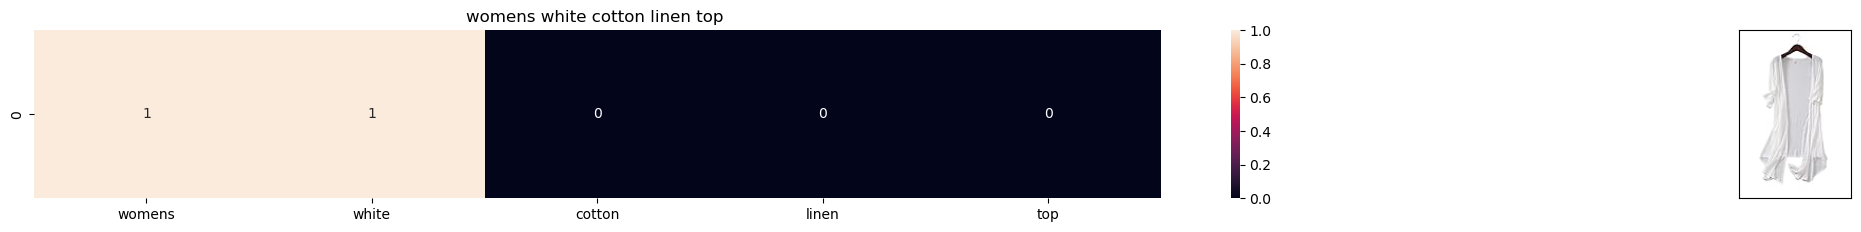

Asin : B00ZZPR4Y0
Brand : HP-LEISURE
Title : womens white cotton linen top 
Euclidian similarity with the query image : 3.7416573867739413
************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------
Average euclidean distance = 3.3691305148003954


In [71]:
#call the bag-of-words model for a product to get similar products.
print('Getting the similar items for document id and number of items')
bag_of_words_model(105, 20)

# [6.2] TF-IDF on product tiltes

In [14]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
tfidf_title_features.get_shape()

(16466, 12689)

In [72]:
def tfidf_model(doc_ID, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features, tfidf_title_features[doc_ID])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the {num_results} smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], "tfidf")
        print(f"Asin : {data['asin'].loc[df_indices[i]]}")
        print(f"Brand : {data['brand'].loc[df_indices[i]]}")
        print(f"Title : {data['title'].loc[df_indices[i]]}")
        print(f"Euclidean distance from given image : {pdists[i]}")
        print('*'*120)
    print("-"*120)
    print(f"Average euclidean distance = {sum(pdists) / len(pdists)}")

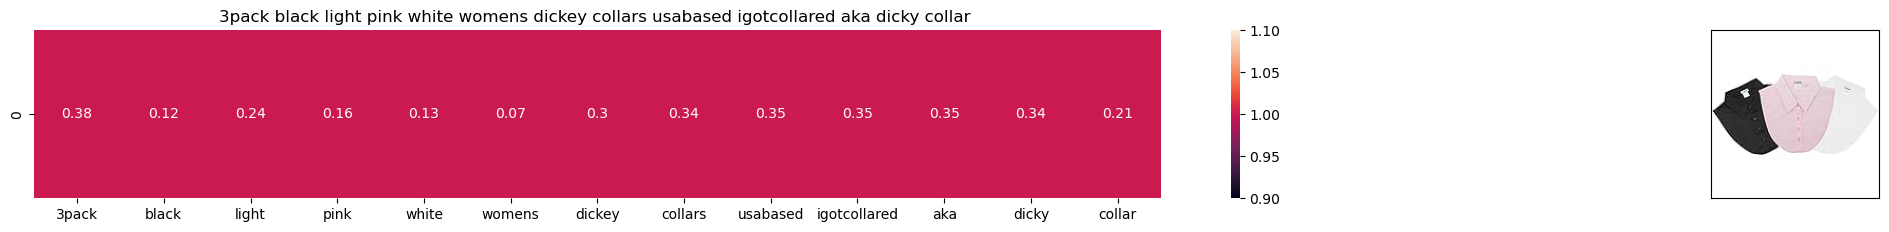

Asin : B01N2W9P7A
Brand : IGotCollared Pronounced I Got Collared
Title : 3pack black light pink white womens dickey collars usabased igotcollared aka dicky collar 
Euclidean distance from given image : 0.0
************************************************************************************************************************


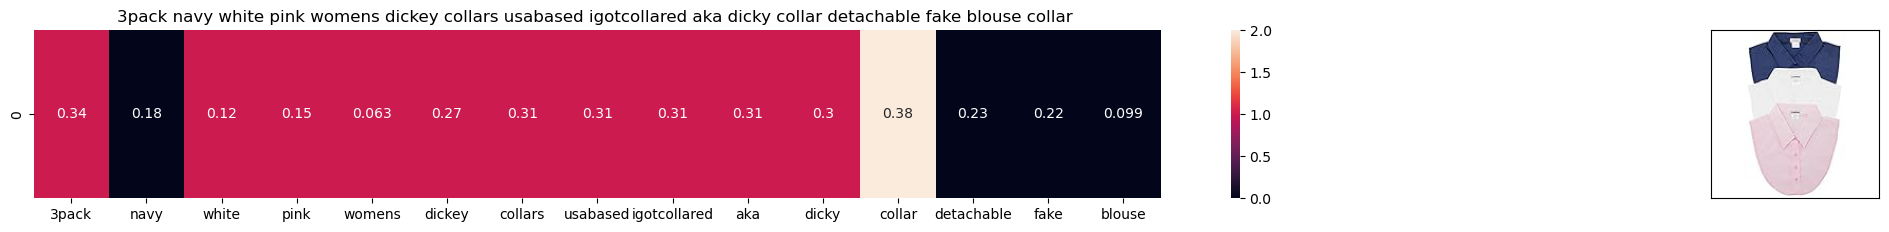

Asin : B01MZ24OV9
Brand : IGotCollared Pronounced I Got Collared
Title : 3pack navy white pink womens dickey collars usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.5014069254186102
************************************************************************************************************************


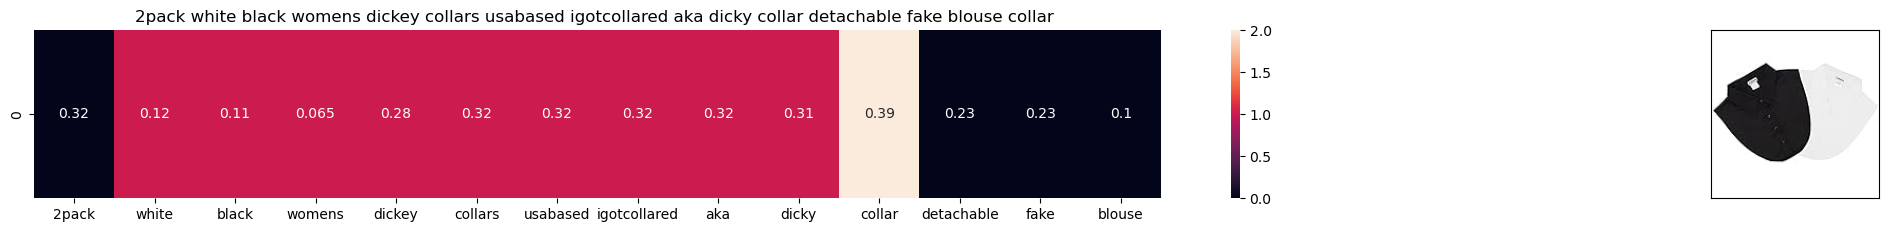

Asin : B01N4GCBUM
Brand : IGotCollared Pronounced I Got Collared
Title : 2pack white black womens dickey collars usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.6967659004031725
************************************************************************************************************************


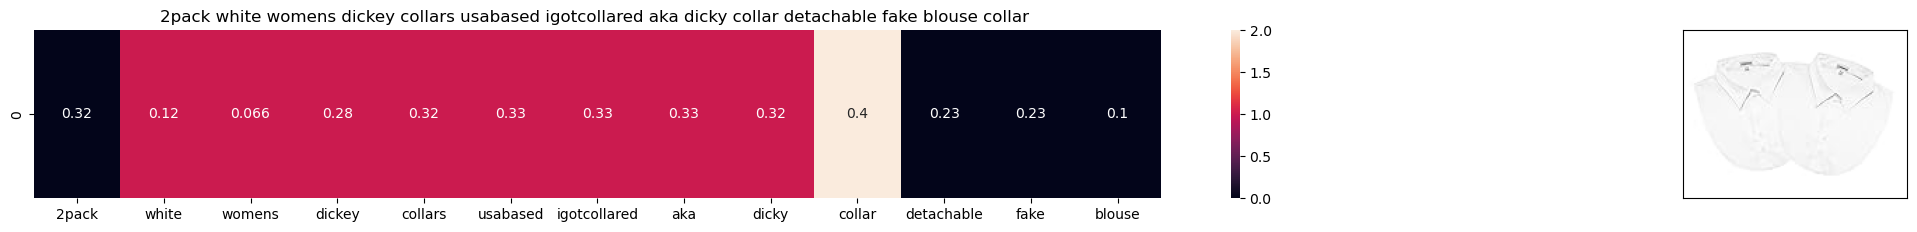

Asin : B01N9JYI2N
Brand : IGotCollared Pronounced I Got Collared
Title : 2pack white womens dickey collars usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.7082625999079875
************************************************************************************************************************


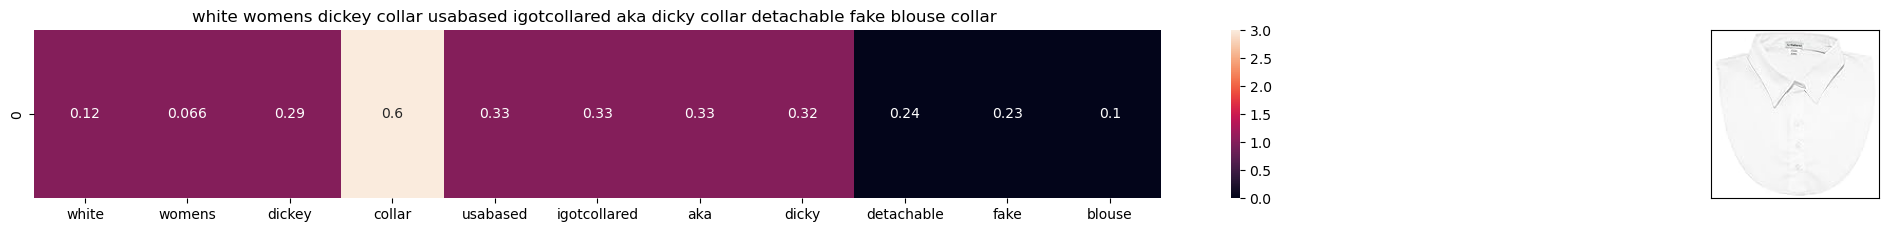

Asin : B01NCM39R4
Brand : IGotCollared
Title : white womens dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.7941076638118596
************************************************************************************************************************


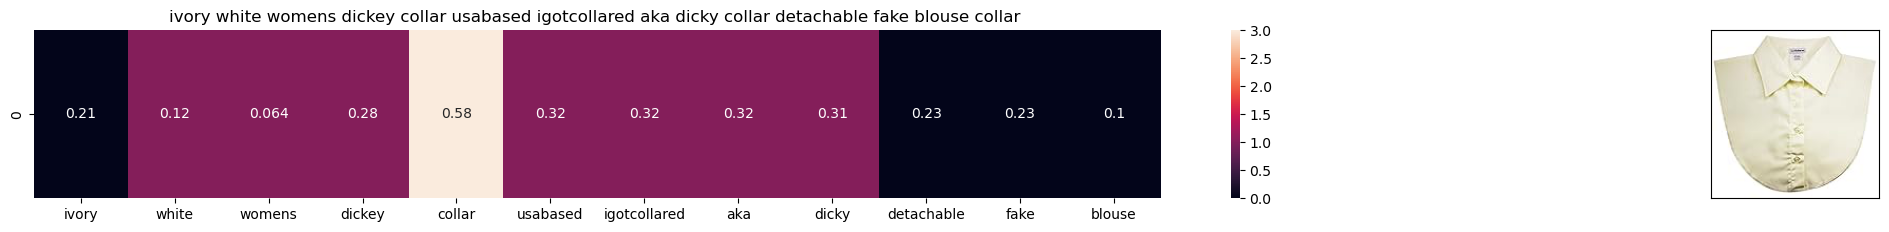

Asin : B01MRUN3UC
Brand : IGotCollared
Title : ivory white womens dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.8124379177806621
************************************************************************************************************************


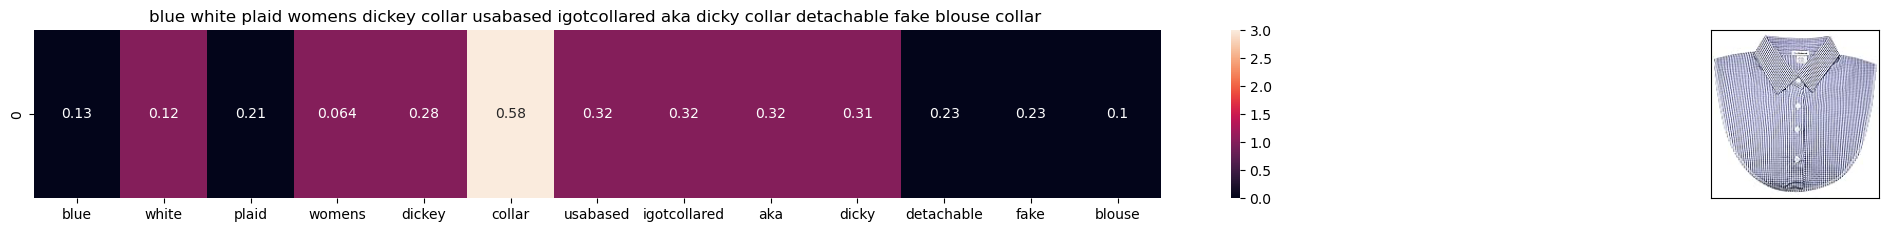

Asin : B01MRXXYMA
Brand : IGotCollared
Title : blue white plaid womens dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.8200422680724342
************************************************************************************************************************


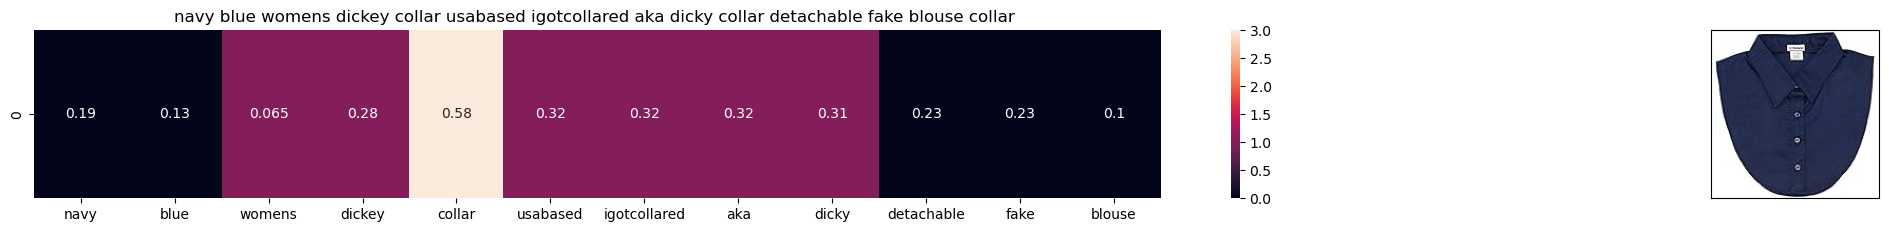

Asin : B01NGYF4IJ
Brand : IGotCollared
Title : navy blue womens dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.8301831731036636
************************************************************************************************************************


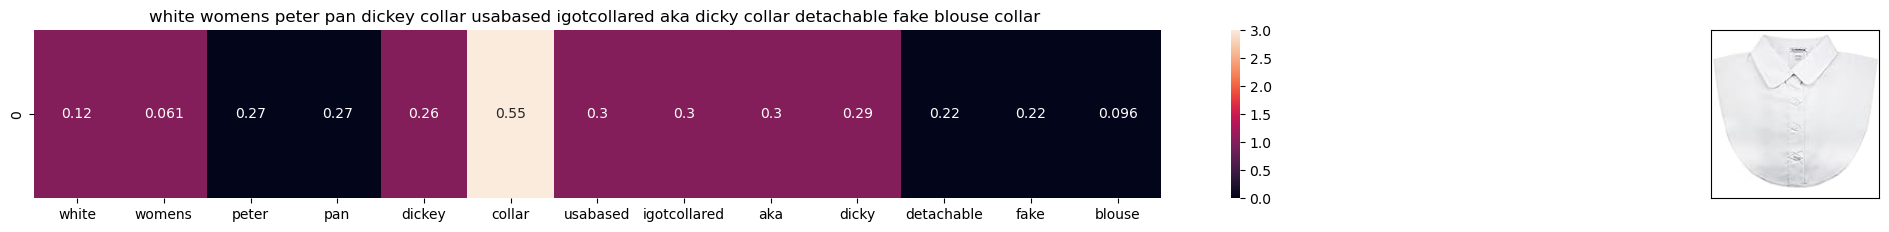

Asin : B01MXYRL6J
Brand : IGotCollared
Title : white womens peter pan dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.8580075507456189
************************************************************************************************************************


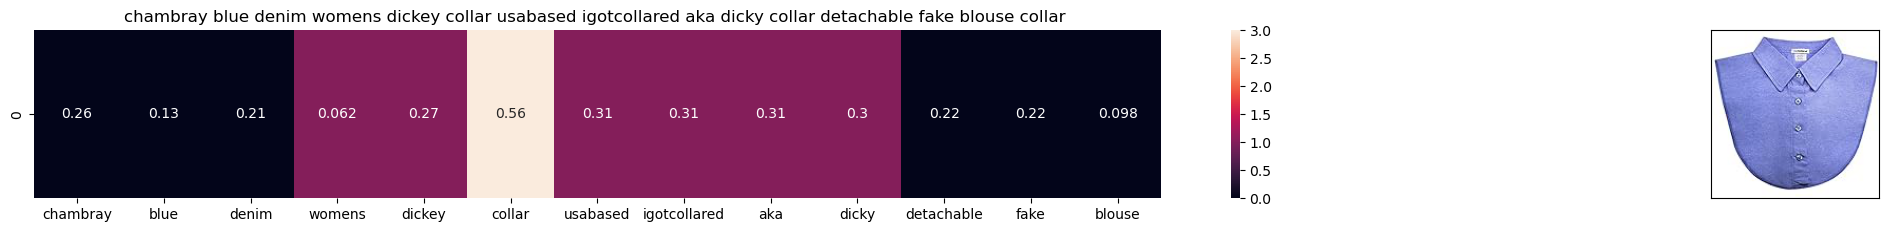

Asin : B01MQWKWME
Brand : IGotCollared
Title : chambray blue denim womens dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean distance from given image : 0.8624388072305431
************************************************************************************************************************


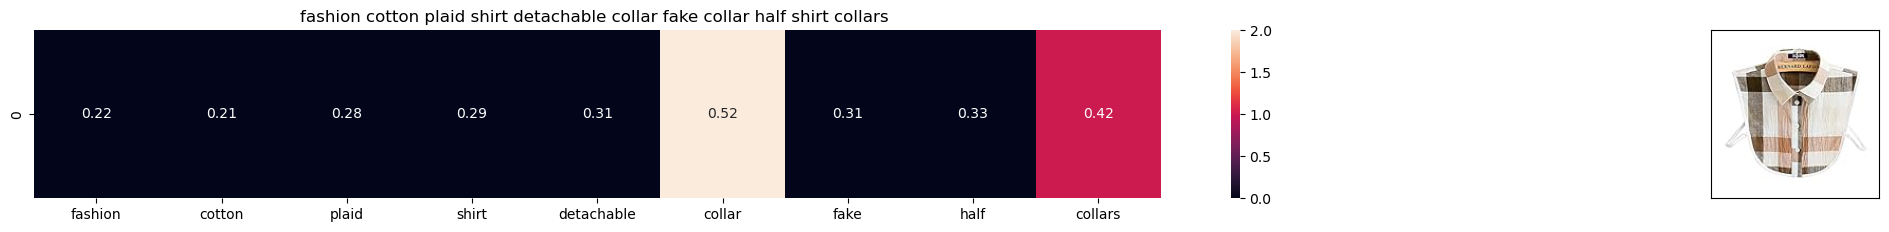

Asin : B06WGWKQFF
Brand : George Jimmy
Title : fashion cotton plaid shirt detachable collar fake collar half shirt collars 
Euclidean distance from given image : 1.2216877534077974
************************************************************************************************************************


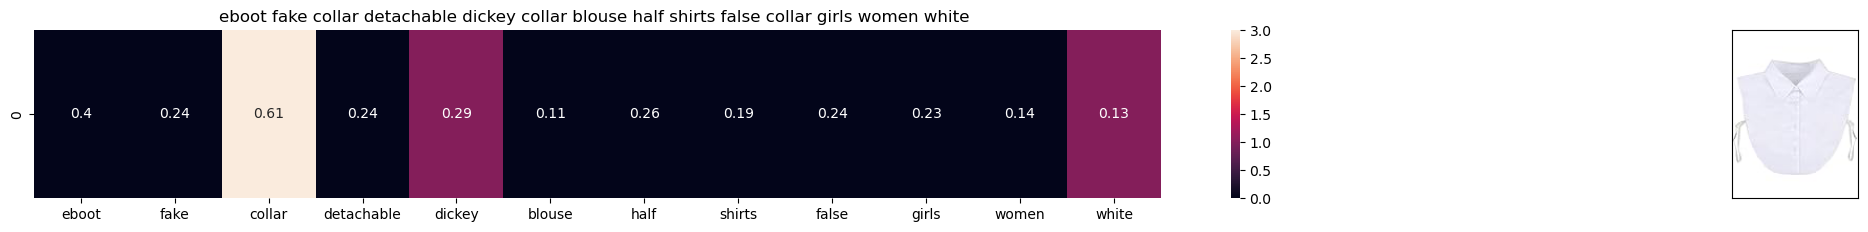

Asin : B01N230VOY
Brand : eBoot
Title : eboot fake collar detachable dickey collar blouse half shirts false collar girls women white 
Euclidean distance from given image : 1.2365812896685644
************************************************************************************************************************


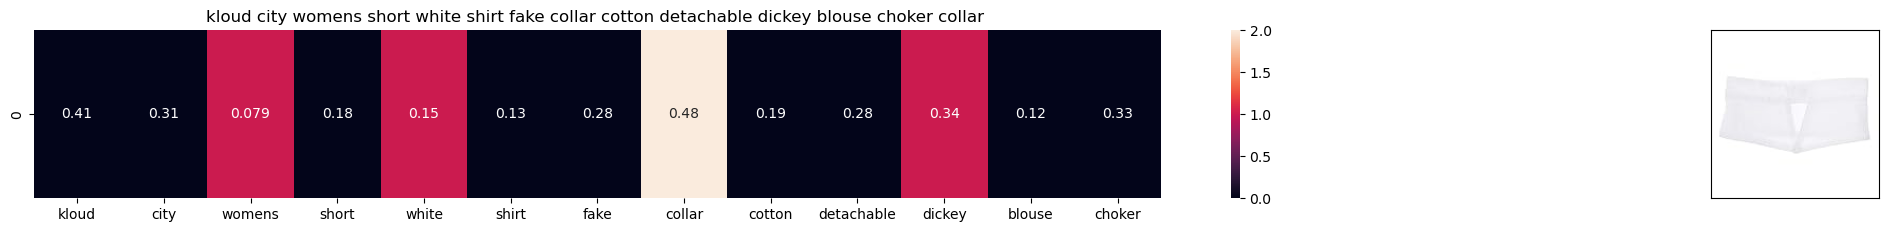

Asin : B01MZ1OMK9
Brand : KLOUD City
Title : kloud city womens short white shirt fake collar cotton detachable dickey blouse choker collar 
Euclidean distance from given image : 1.2410784997024469
************************************************************************************************************************


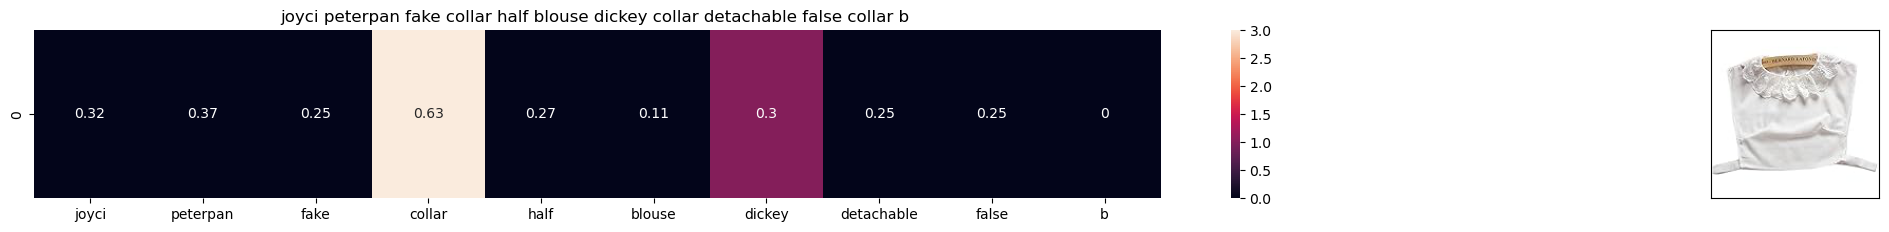

Asin : B01M29GPK7
Brand : Joyci
Title : joyci peterpan fake collar half blouse dickey collar detachable false collar b 
Euclidean distance from given image : 1.243796499060962
************************************************************************************************************************


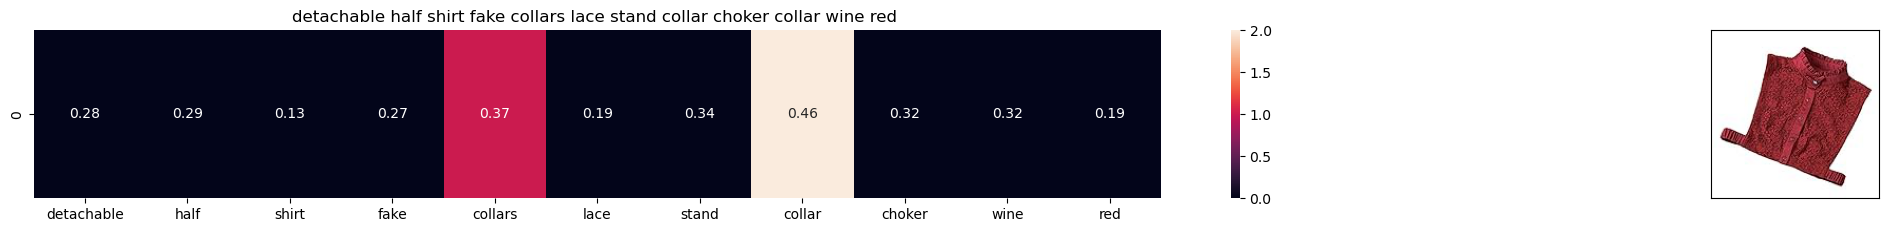

Asin : B01MSNTHAM
Brand : Panda Superstore
Title : detachable half shirt fake collars lace stand collar choker collar wine red 
Euclidean distance from given image : 1.2439042136882315
************************************************************************************************************************


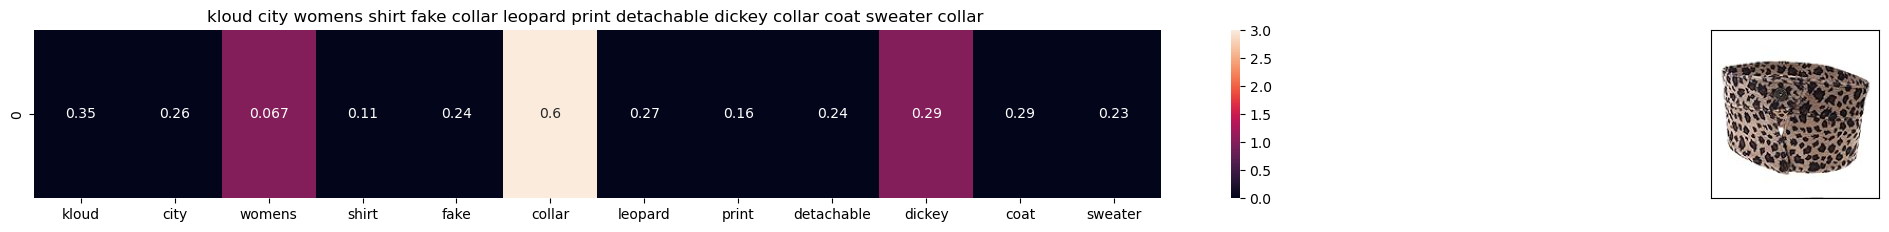

Asin : B01NBM80SP
Brand : KLOUD City
Title : kloud city womens shirt fake collar leopard print detachable dickey collar coat sweater collar 
Euclidean distance from given image : 1.2485841173178553
************************************************************************************************************************


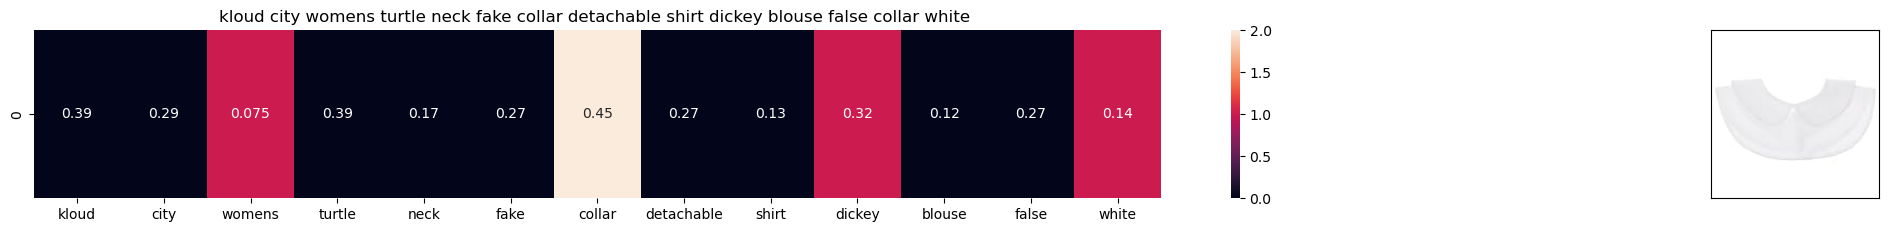

Asin : B01N7IVVAJ
Brand : KLOUD City
Title : kloud city womens turtle neck fake collar detachable shirt dickey blouse false collar white 
Euclidean distance from given image : 1.2499337326848132
************************************************************************************************************************


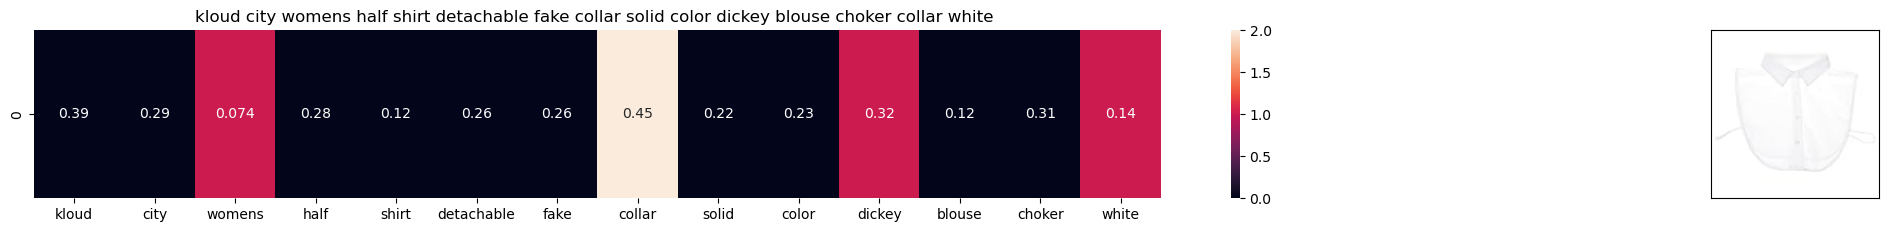

Asin : B01MU2K4EU
Brand : KLOUD City
Title : kloud city womens half shirt detachable fake collar solid color dickey blouse choker collar white 
Euclidean distance from given image : 1.2525856037011076
************************************************************************************************************************


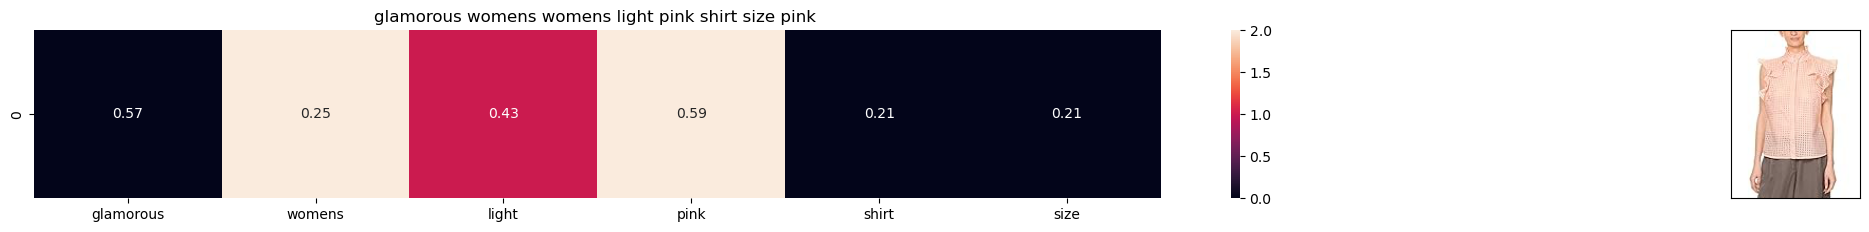

Asin : B06Y3ZMZW1
Brand : Glamorous
Title : glamorous womens womens light pink shirt size pink 
Euclidean distance from given image : 1.2527498657401162
************************************************************************************************************************


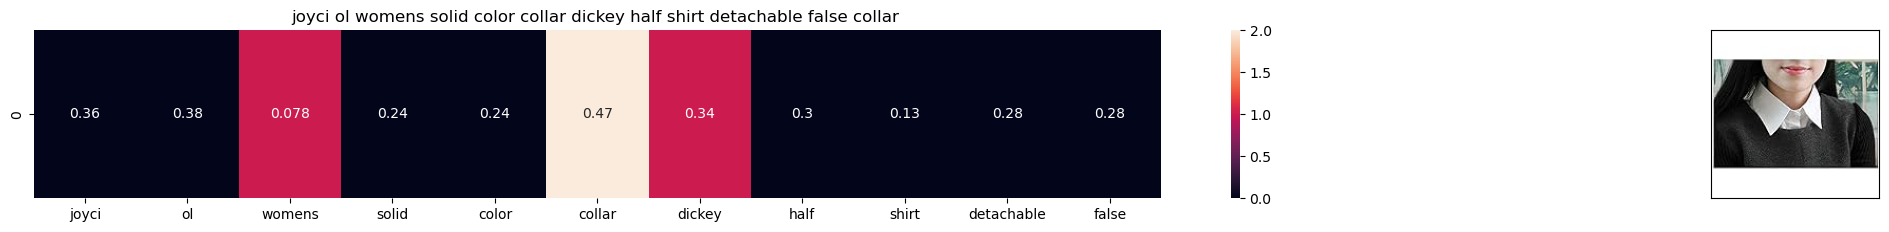

Asin : B0183L5FIE
Brand : Joyci
Title : joyci ol womens solid color collar dickey half shirt detachable false collar 
Euclidean distance from given image : 1.2575546578709489
************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------
Average euclidean distance = 0.9666054519658698


In [73]:
tfidf_model(105, 20)

# [6.3] IDF of product titles

In [22]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])
idf_title_features.get_shape()

(16466, 12689)

In [23]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [26]:
# # we need to convert the values into float
# idf_title_features  = idf_title_features.astype(np.float64)

# for i in idf_title_vectorizer.vocabulary_.keys():
#     # for every word in whole corpus we will find its idf value
#     idf_val = idf(i)
    
#     # to calculate idf_title_features we need to replace the count values with the idf values of the word
#     # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
#     for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
#         # we replace the count values of word i in document j with  idf_value of word i 
#         # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
#         idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [68]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('*'*125)
    print(f"Average euclidean distance: {sum(pdists) / len(pdists)}")

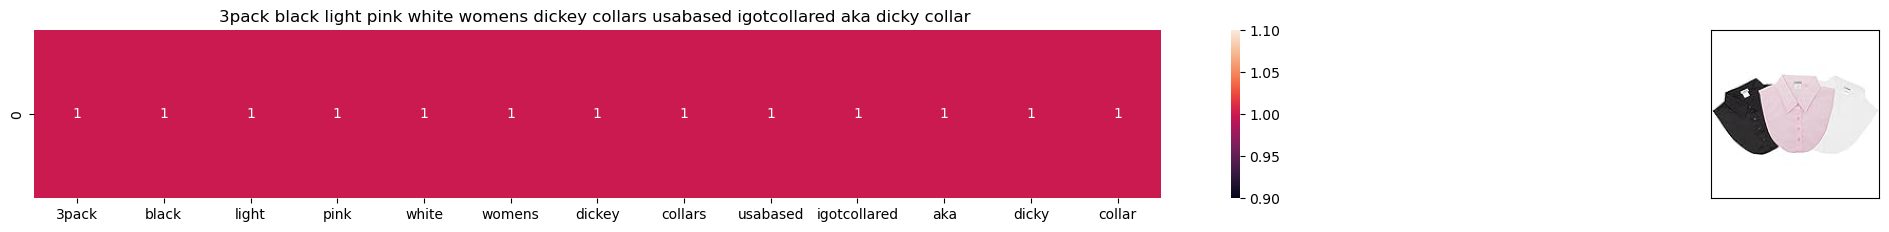

ASIN : B01N2W9P7A
Brand : IGotCollared Pronounced I Got Collared
euclidean distance from the given image : 0.0
*****************************************************************************************************************************


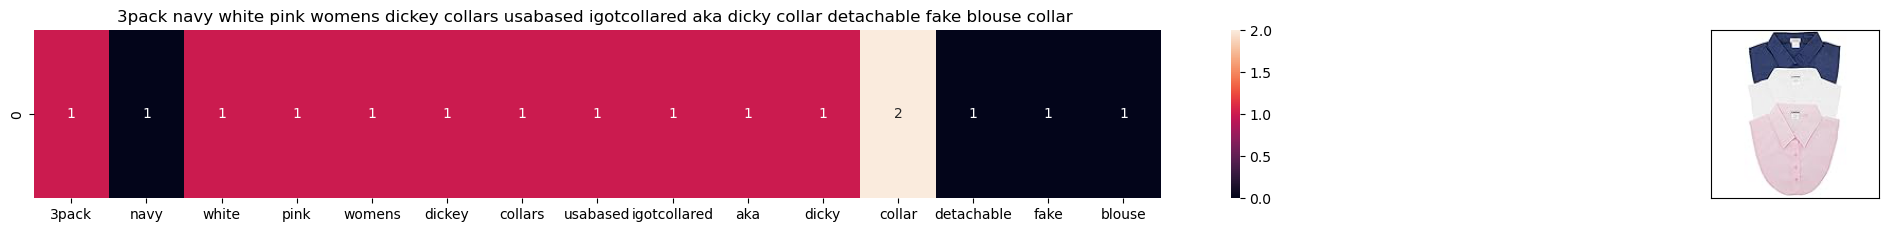

ASIN : B01MZ24OV9
Brand : IGotCollared Pronounced I Got Collared
euclidean distance from the given image : 2.6457513110645907
*****************************************************************************************************************************


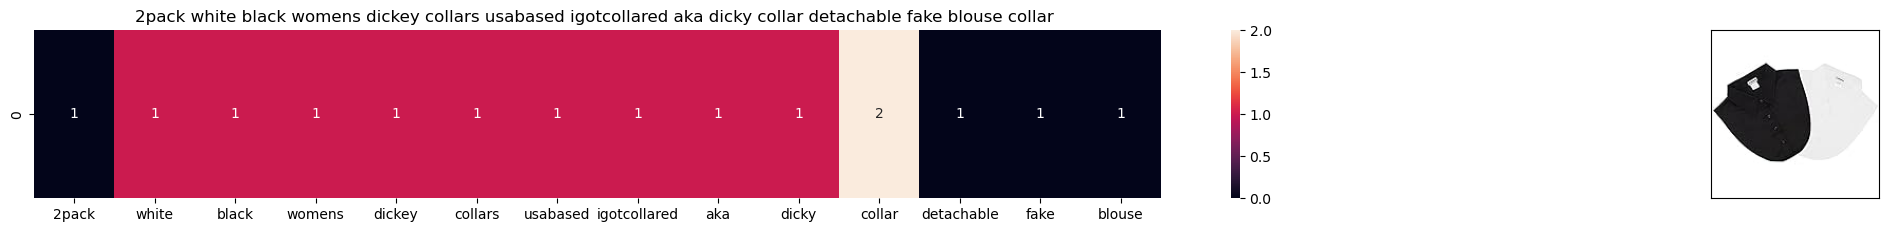

ASIN : B01N4GCBUM
Brand : IGotCollared Pronounced I Got Collared
euclidean distance from the given image : 2.8284271247461903
*****************************************************************************************************************************


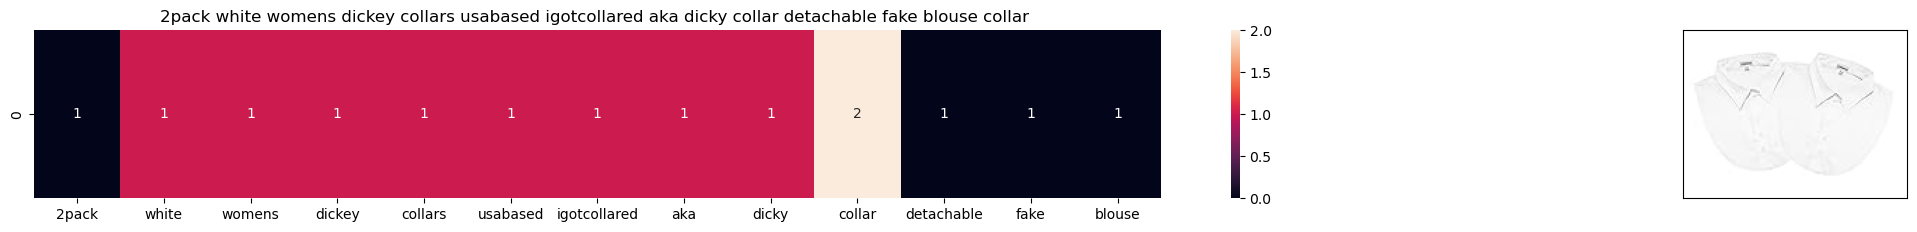

ASIN : B01N9JYI2N
Brand : IGotCollared Pronounced I Got Collared
euclidean distance from the given image : 3.0
*****************************************************************************************************************************


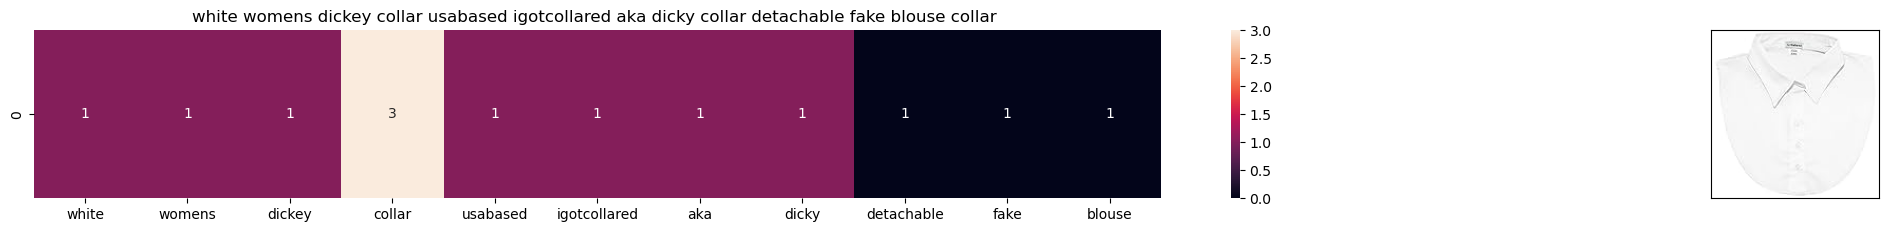

ASIN : B01NCM39R4
Brand : IGotCollared
euclidean distance from the given image : 3.4641016151377544
*****************************************************************************************************************************


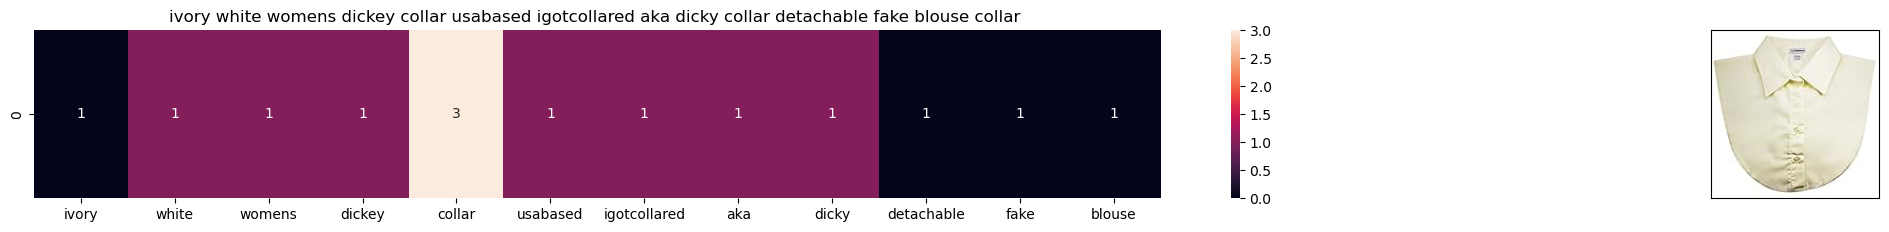

ASIN : B01MRUN3UC
Brand : IGotCollared
euclidean distance from the given image : 3.605551275463989
*****************************************************************************************************************************


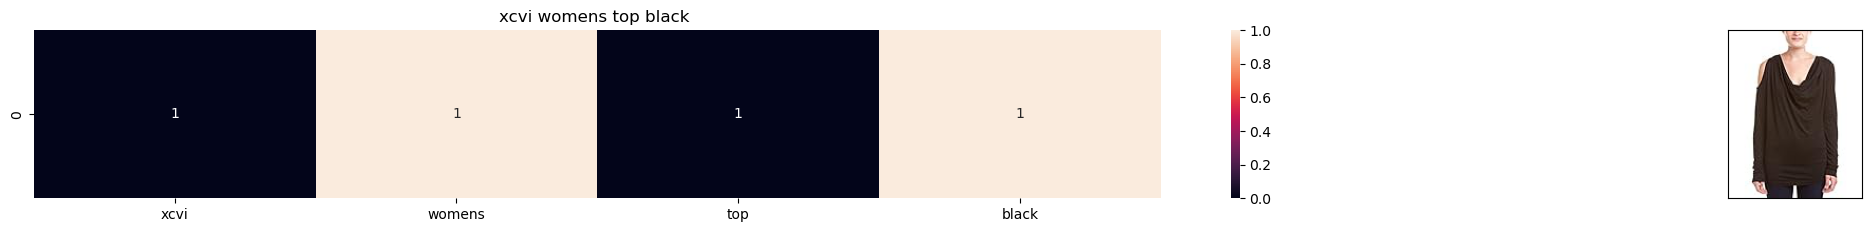

ASIN : B01NB9C9Z4
Brand : XCVI
euclidean distance from the given image : 3.605551275463989
*****************************************************************************************************************************


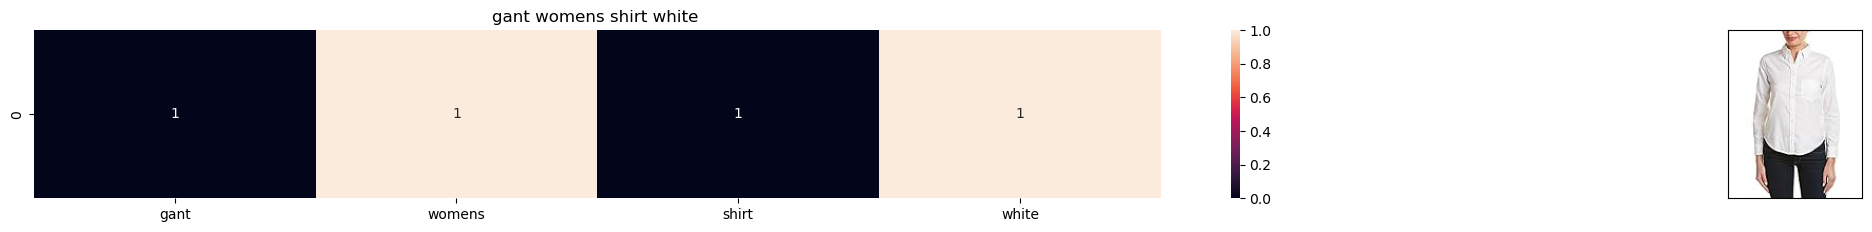

ASIN : B01N80ZGZX
Brand : GANT
euclidean distance from the given image : 3.605551275463989
*****************************************************************************************************************************


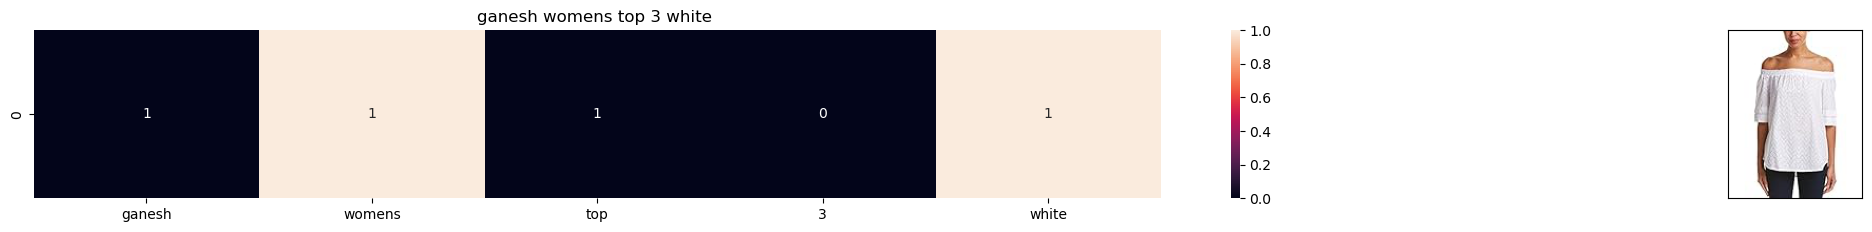

ASIN : B071VY45DD
Brand : Ganesh
euclidean distance from the given image : 3.605551275463989
*****************************************************************************************************************************


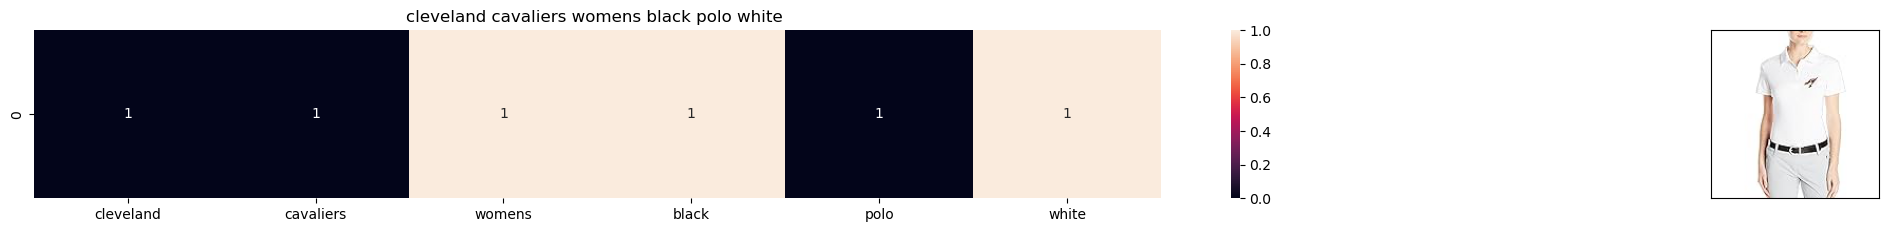

ASIN : B01G1LXTDQ
Brand : zhoujie
euclidean distance from the given image : 3.605551275463989
*****************************************************************************************************************************


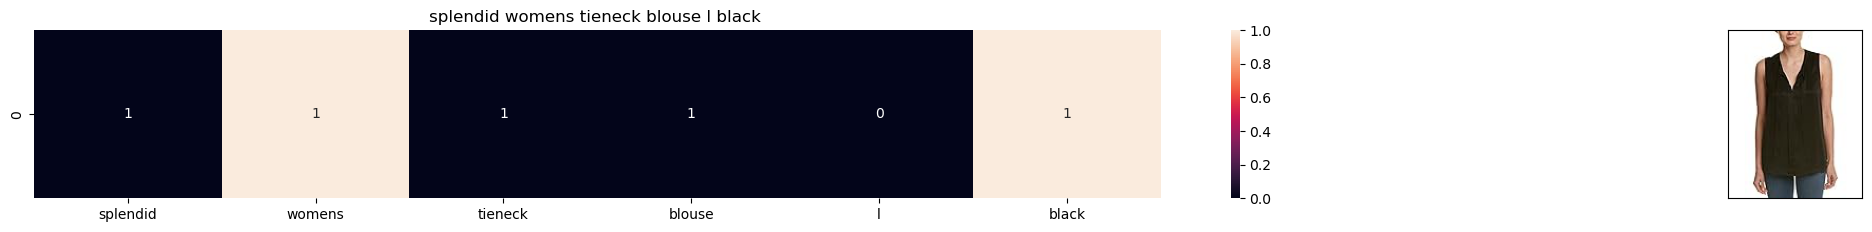

ASIN : B0716F4X2L
Brand : Splendid
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


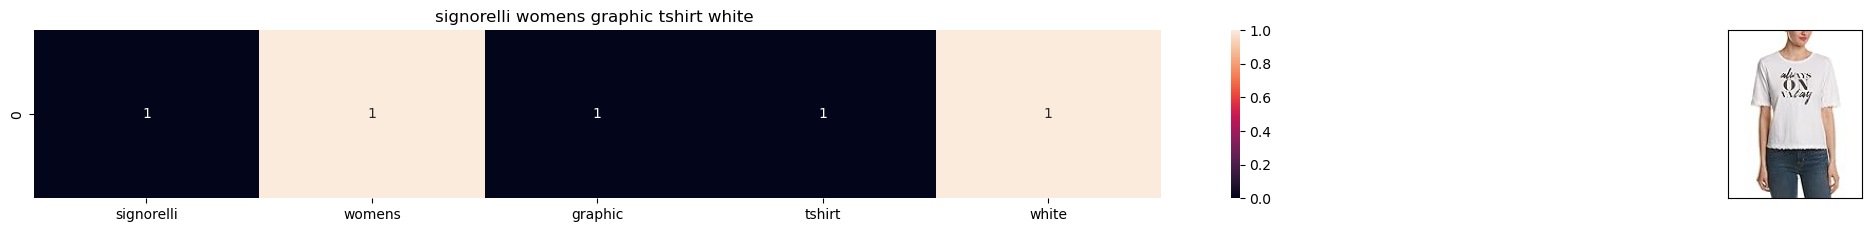

ASIN : B07119RDQ1
Brand : Signorelli
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


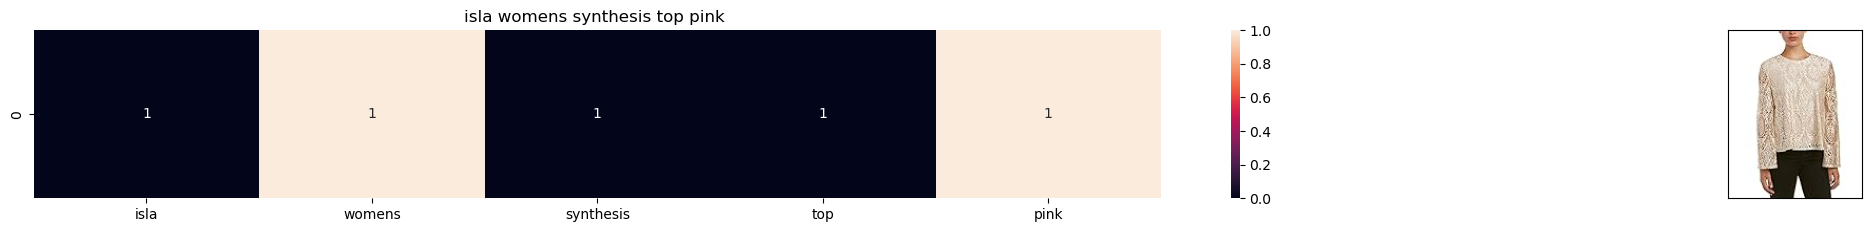

ASIN : B074MGBYCD
Brand : Isla
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


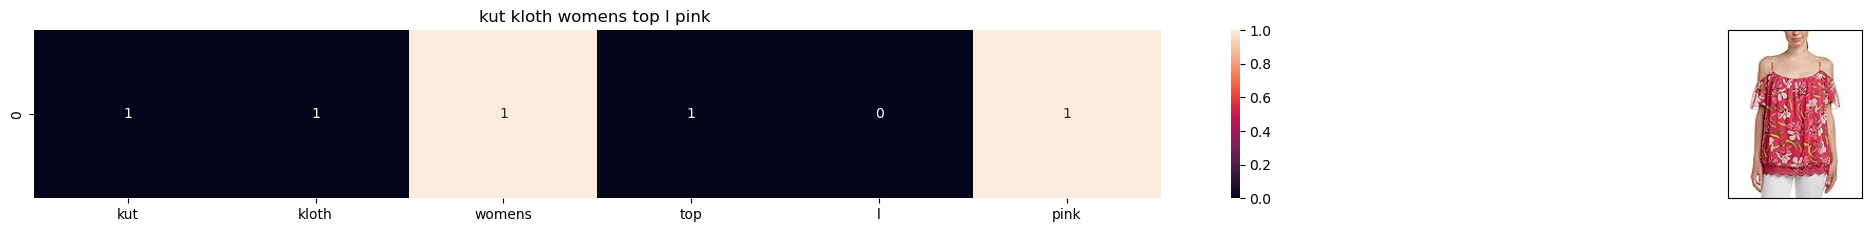

ASIN : B07485W6NF
Brand : KUT from the Kloth
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


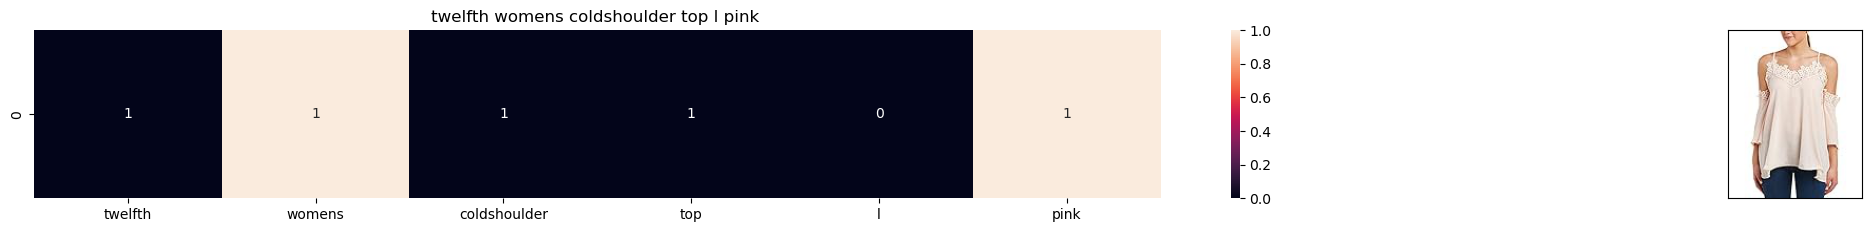

ASIN : B074F49Q1C
Brand : On Twelfth
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


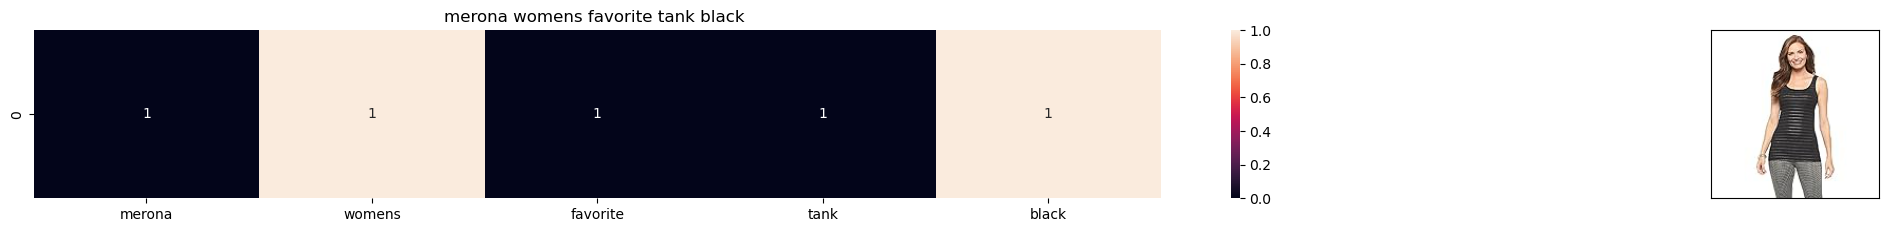

ASIN : B01KBGZE4Y
Brand : Merona
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


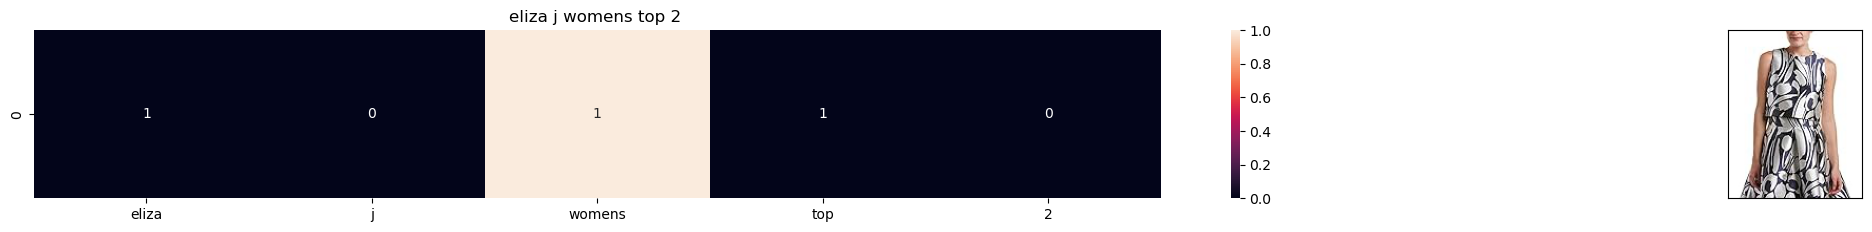

ASIN : B01N0645HW
Brand : Eliza J
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


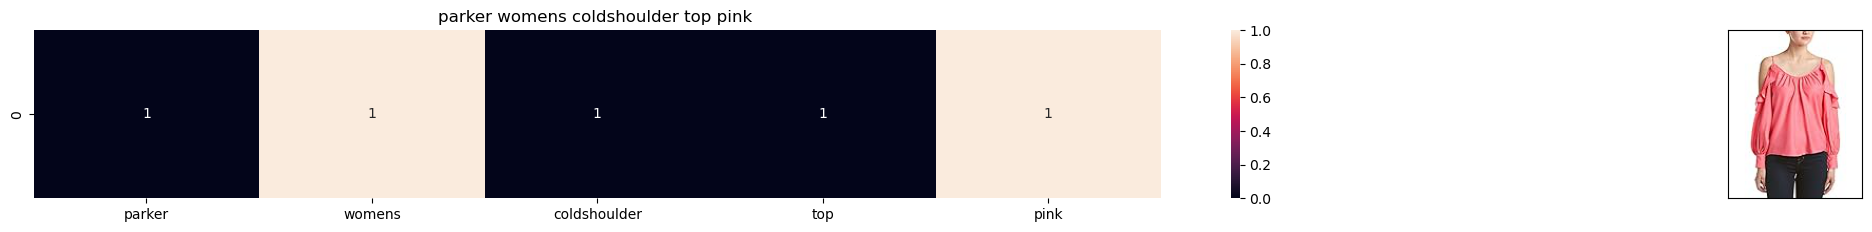

ASIN : B01MZ735IP
Brand : Parker
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


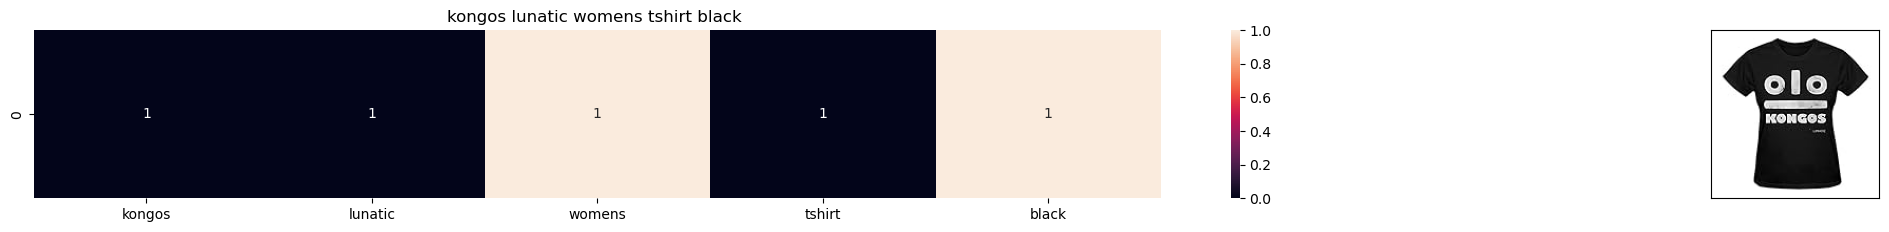

ASIN : B01IXZLJIA
Brand : Moonflow
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************


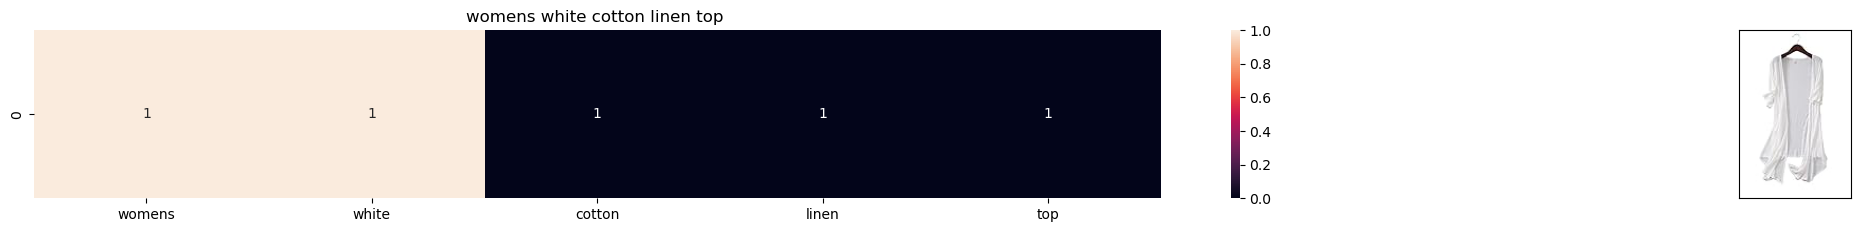

ASIN : B00ZZPR4Y0
Brand : HP-LEISURE
euclidean distance from the given image : 3.7416573867739413
*****************************************************************************************************************************
Average euclidean distance: 3.3691305148003954


In [69]:
idf_model(105, 20)

In [74]:
#Till now we have Tf-Idf > BoW > Idf

# [6.4] Weighted euclidean distance using brand and color

In [28]:
# Some of the brand values are NaN.
# Replacin NaN with string "Not Given"
data['brand'].fillna(value = "Not Given", inplace = True)

In [29]:
# Replacing spaces with hyphens
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [30]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
tfidf_title_features.get_shape()

(16466, 12689)

In [75]:
def idf_brand_sim(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  title features
    # w2: weight for brand and color features
    pairwise_dist = pairwise_distances(tfidf_title_features, tfidf_title_features[doc_id])
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * pairwise_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('*'*125)
    print("-"*120)
    print('Average euclidean distance is ',sum(pdists)/len(pdists))

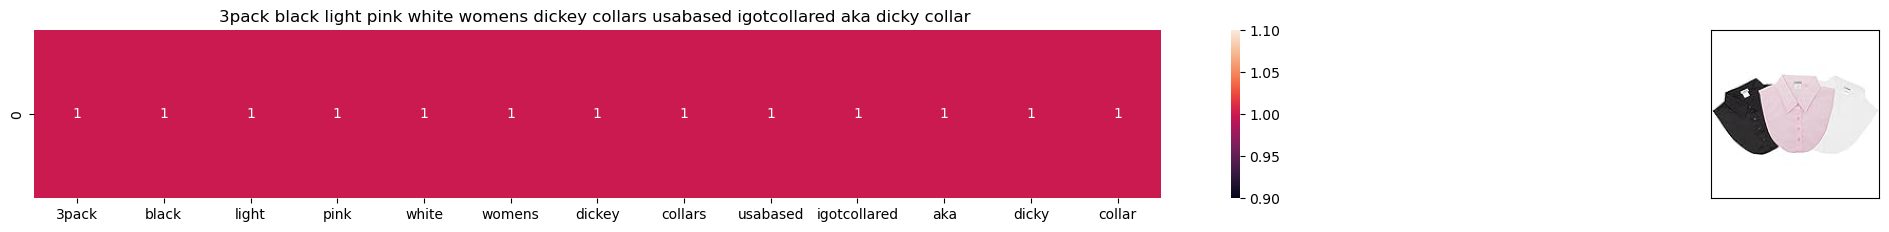

ASIN : B01N2W9P7A
Brand : IGotCollared Pronounced I Got Collared
euclidean distance from input : 0.0
*****************************************************************************************************************************


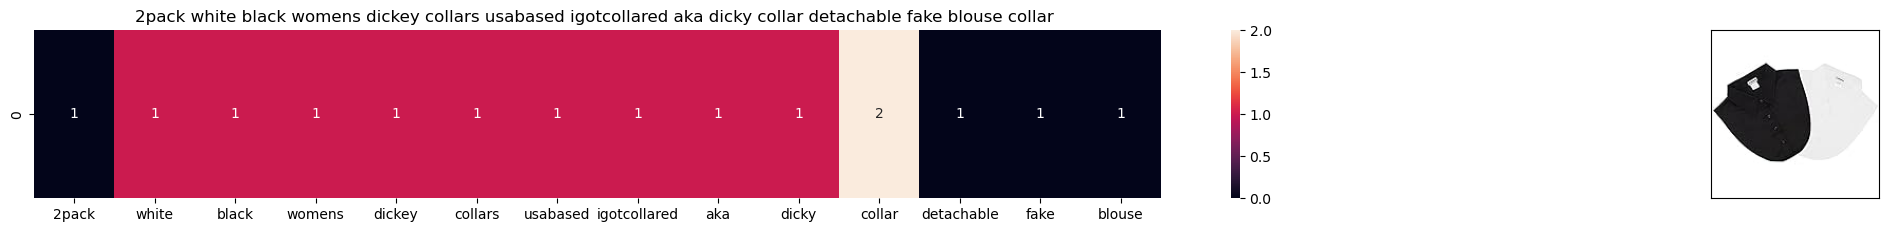

ASIN : B01N4GCBUM
Brand : IGotCollared Pronounced I Got Collared
euclidean distance from input : 0.7834042145736947
*****************************************************************************************************************************


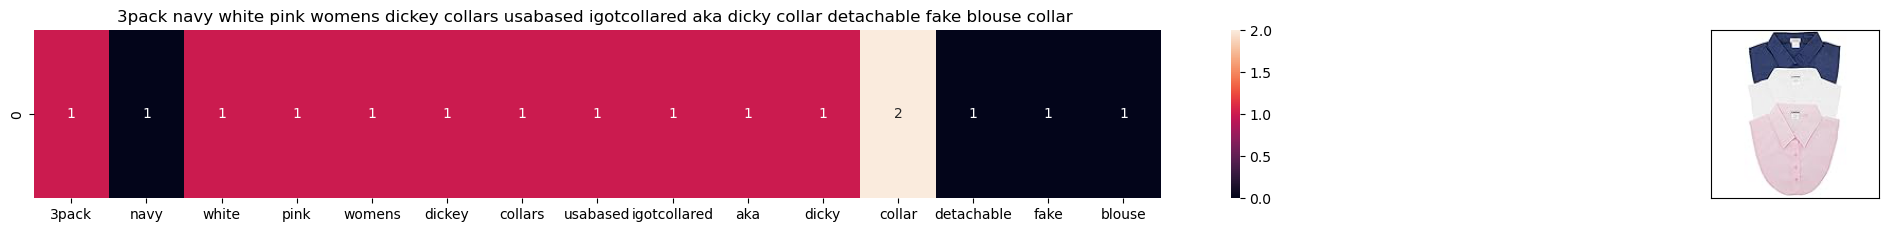

ASIN : B01MZ24OV9
Brand : IGotCollared Pronounced I Got Collared
euclidean distance from input : 0.8530194631758293
*****************************************************************************************************************************


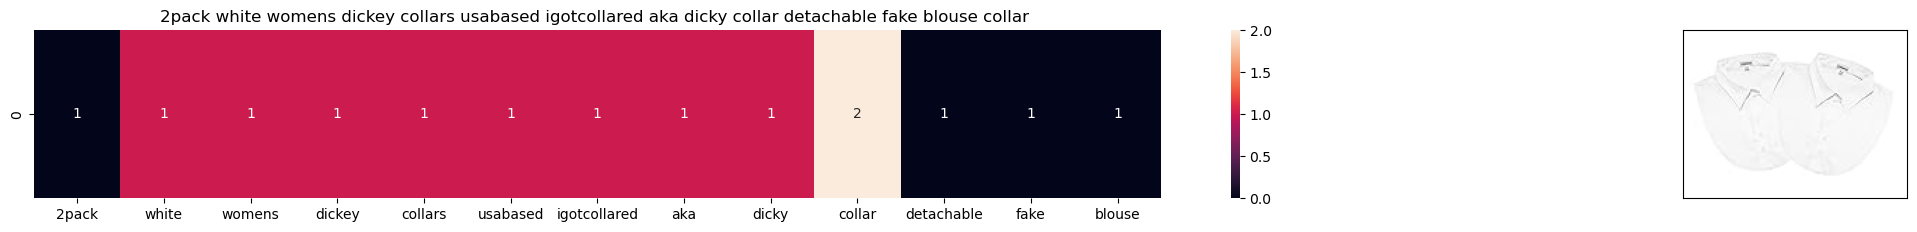

ASIN : B01N9JYI2N
Brand : IGotCollared Pronounced I Got Collared
euclidean distance from input : 0.9099628748980182
*****************************************************************************************************************************


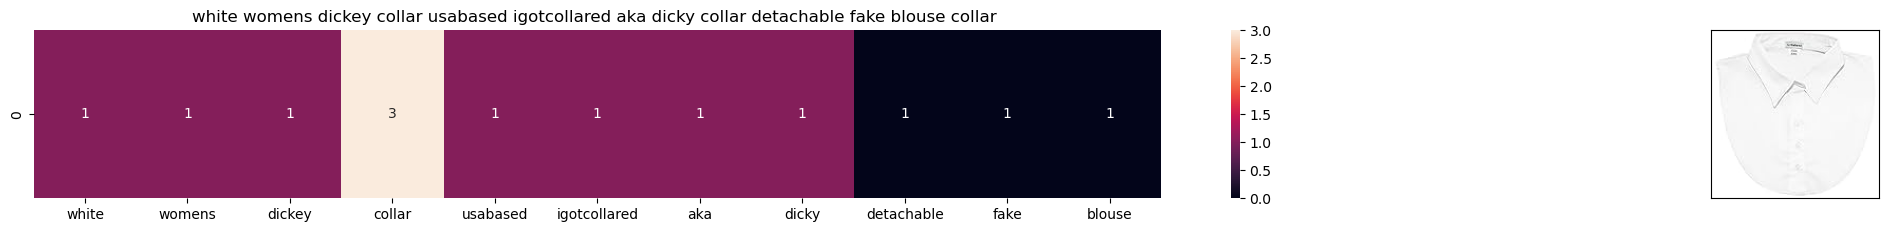

ASIN : B01NCM39R4
Brand : IGotCollared
euclidean distance from input : 1.3231487058840685
*****************************************************************************************************************************


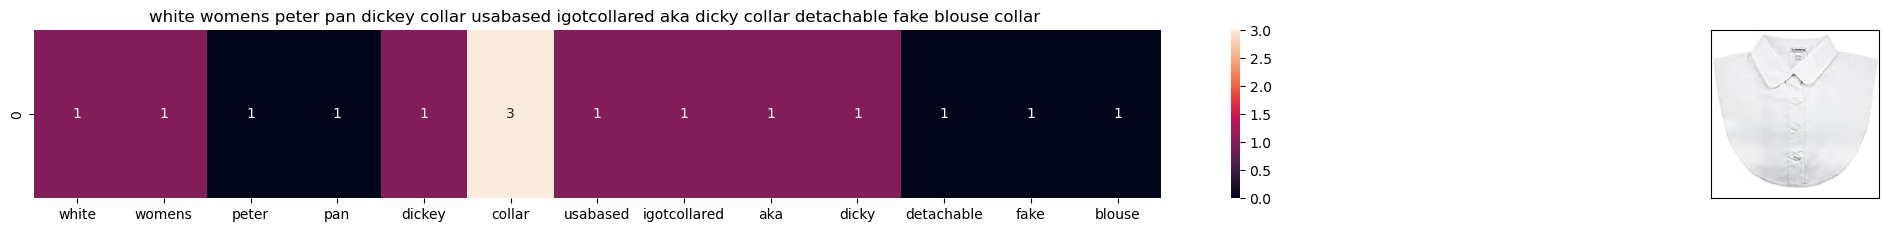

ASIN : B01MXYRL6J
Brand : IGotCollared
euclidean distance from input : 1.368791482265325
*****************************************************************************************************************************


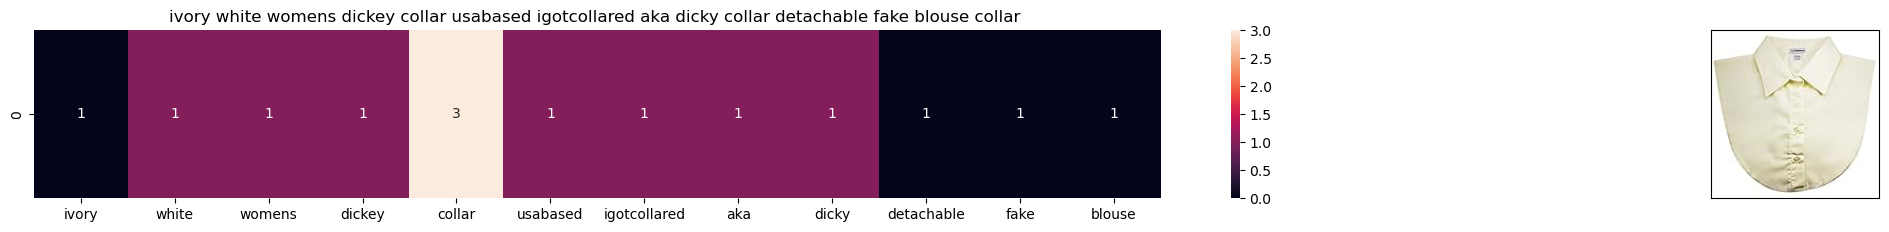

ASIN : B01MRUN3UC
Brand : IGotCollared
euclidean distance from input : 1.437455655557616
*****************************************************************************************************************************


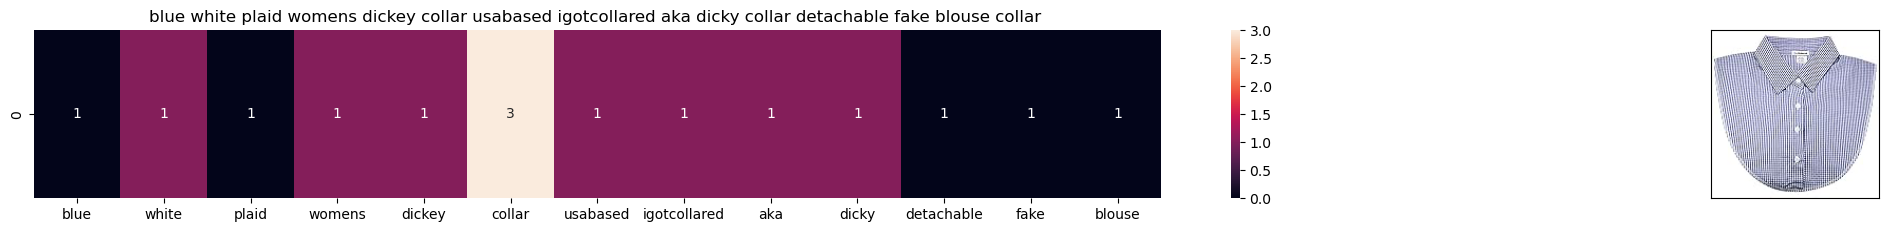

ASIN : B01MRXXYMA
Brand : IGotCollared
euclidean distance from input : 1.4892523800998472
*****************************************************************************************************************************


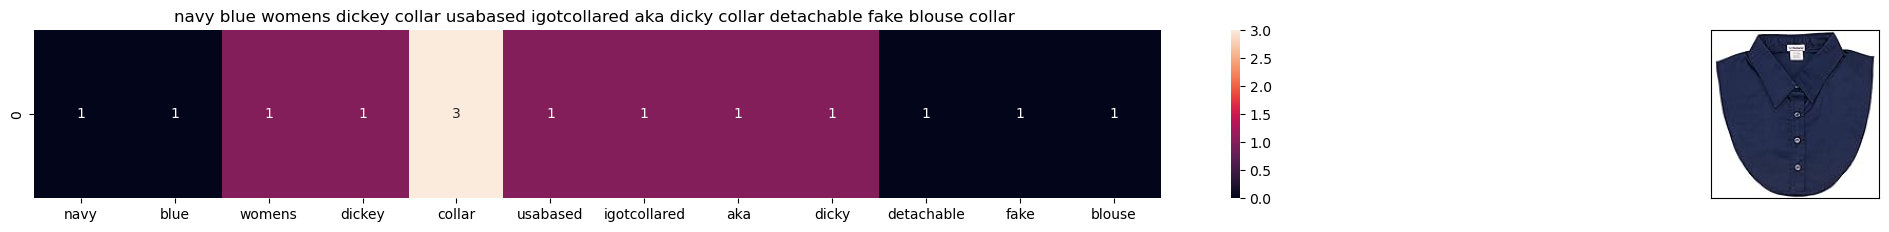

ASIN : B01NGYF4IJ
Brand : IGotCollared
euclidean distance from input : 1.4964958836935824
*****************************************************************************************************************************


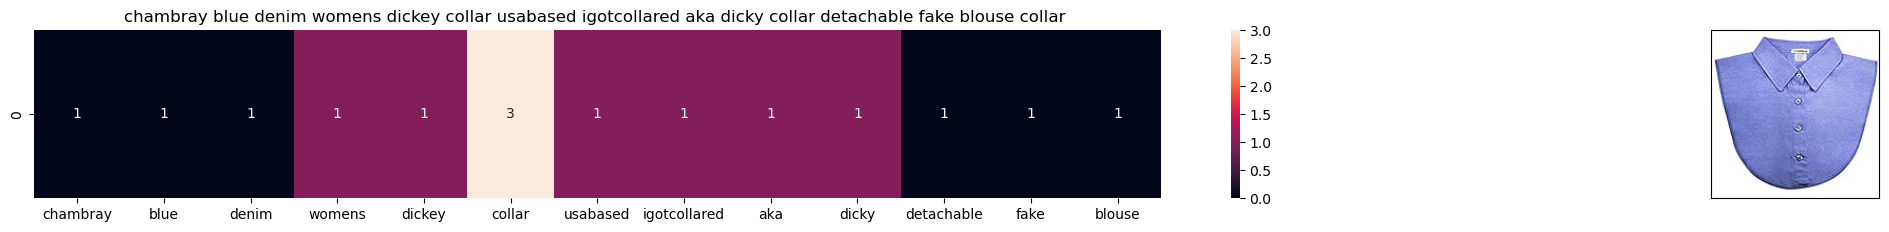

ASIN : B01MQWKWME
Brand : IGotCollared
euclidean distance from input : 1.5636348024090734
*****************************************************************************************************************************


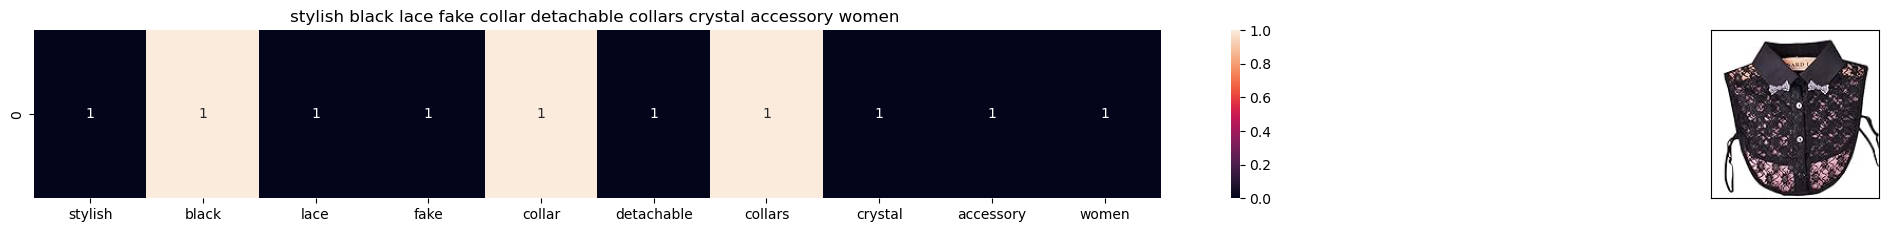

ASIN : B06X1G88GS
Brand : George Jimmy
euclidean distance from input : 1.707740841559515
*****************************************************************************************************************************


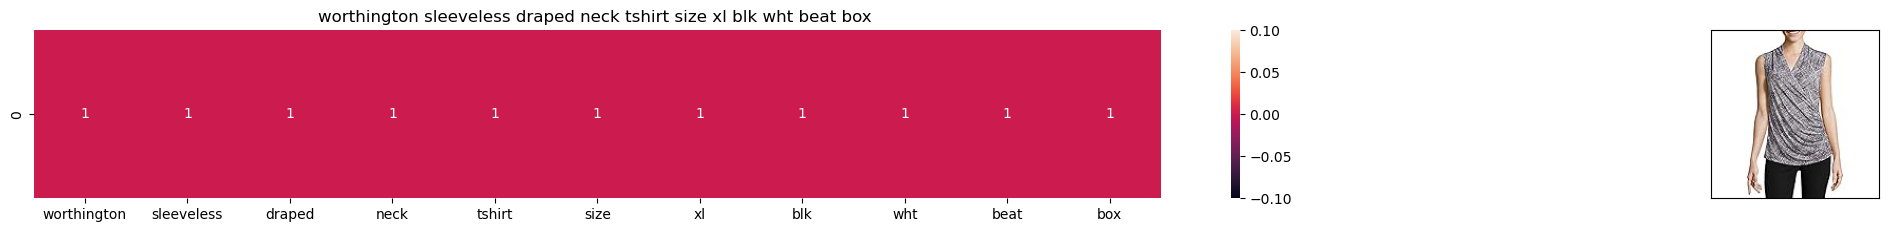

ASIN : B06VXVJ84C
Brand : Worthington
euclidean distance from input : 1.710006756775976
*****************************************************************************************************************************


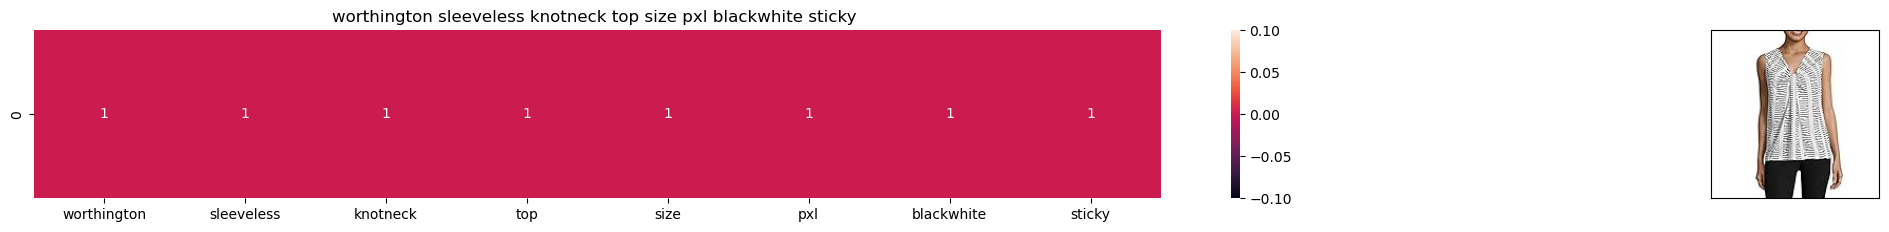

ASIN : B0756SQ1Q3
Brand : Worthington
euclidean distance from input : 1.710006756775976
*****************************************************************************************************************************


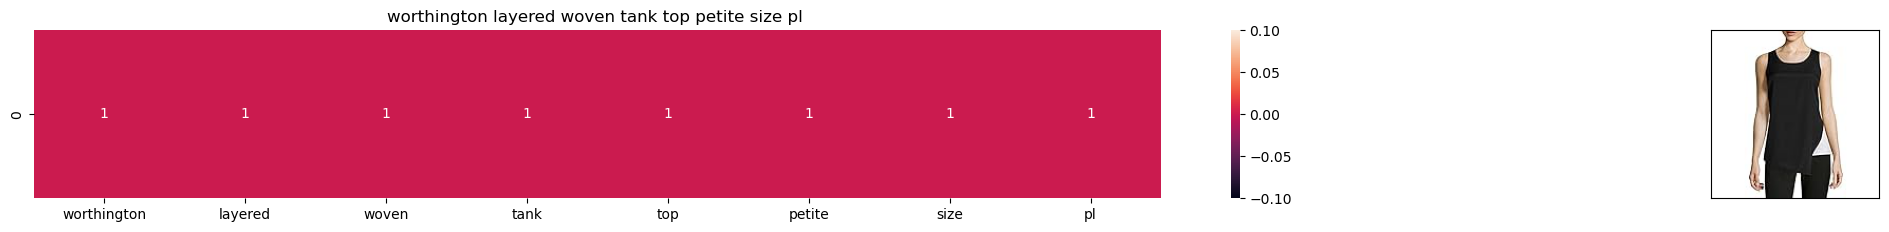

ASIN : B06VY5XYCX
Brand : Worthington
euclidean distance from input : 1.710006756775976
*****************************************************************************************************************************


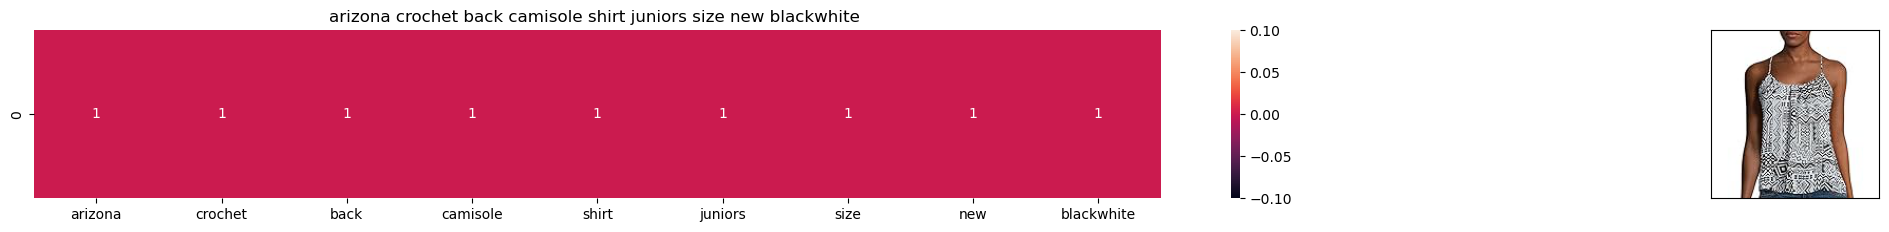

ASIN : B074DS5GXN
Brand : AriZona
euclidean distance from input : 1.710006756775976
*****************************************************************************************************************************


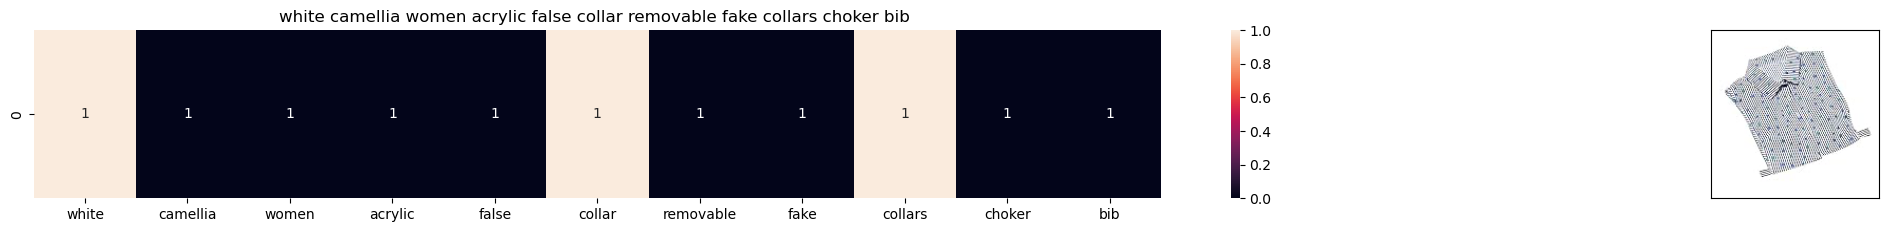

ASIN : B01MSNE3YS
Brand : Panda Superstore
euclidean distance from input : 1.7198152323366964
*****************************************************************************************************************************


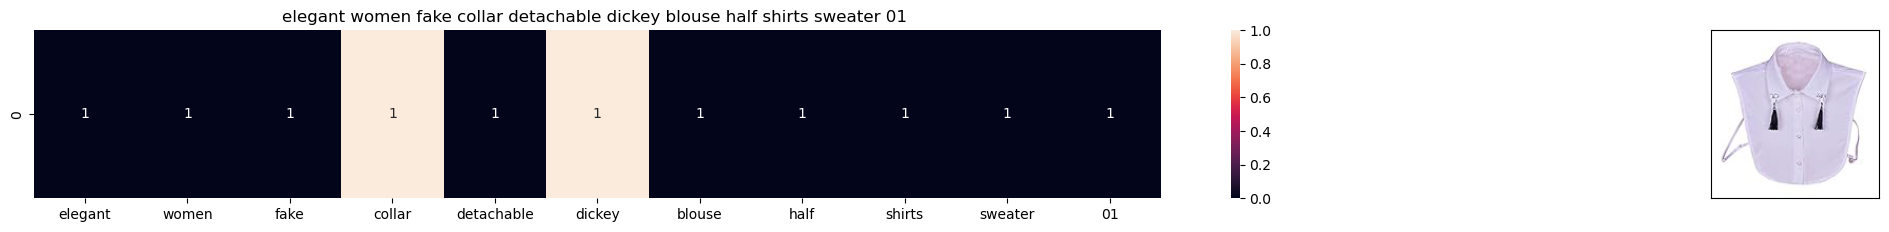

ASIN : B06W5H1BQ5
Brand : George Jimmy
euclidean distance from input : 1.7303610621534657
*****************************************************************************************************************************


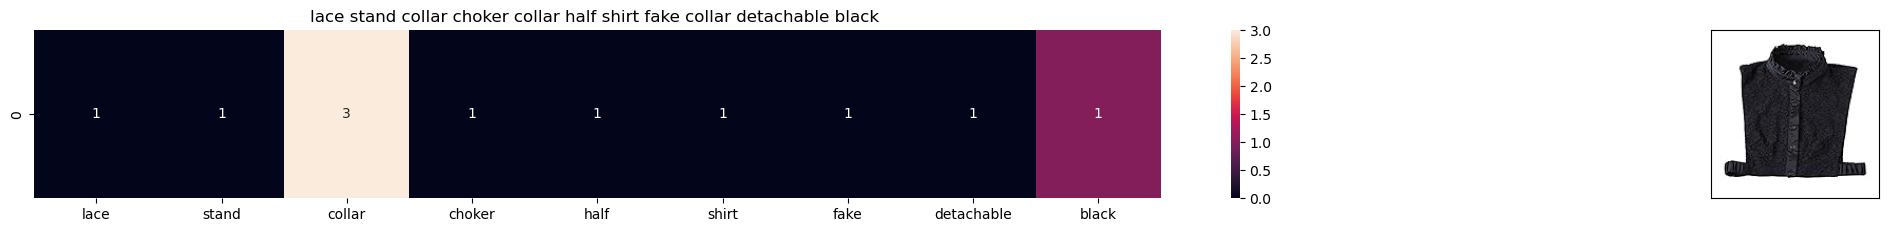

ASIN : B01MXN1B0E
Brand : Panda Superstore
euclidean distance from input : 1.7330392645528072
*****************************************************************************************************************************


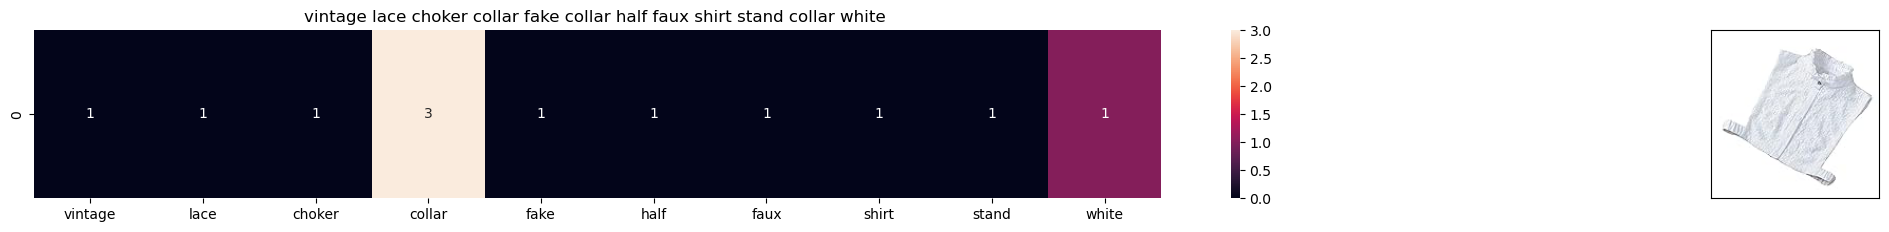

ASIN : B01N0FLWG2
Brand : Panda Superstore
euclidean distance from input : 1.7338301627690693
*****************************************************************************************************************************


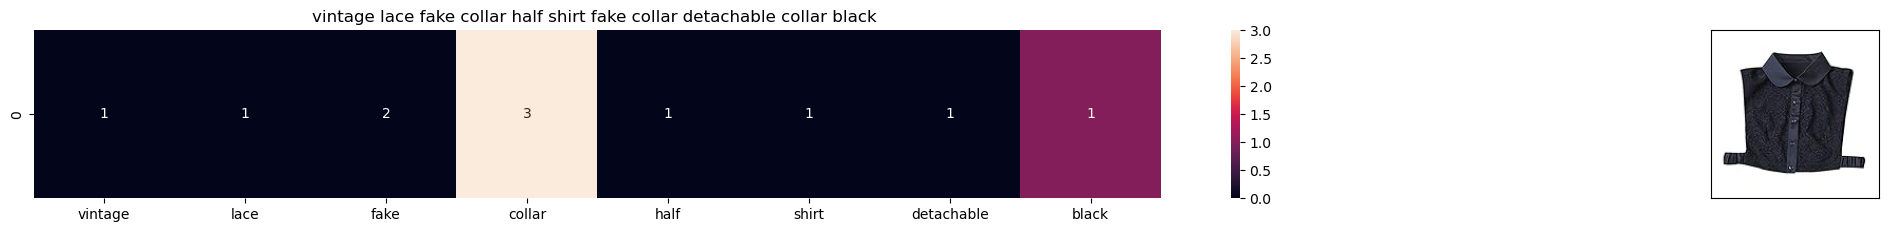

ASIN : B01MXN1AG8
Brand : Panda Superstore
euclidean distance from input : 1.7357994648328625
*****************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------
Average euclidean distance is  1.4212889258932686


In [78]:
idf_brand_sim(105, 50, 20, 20)

In [ ]:
# Now we Have Tf-Idf > Weighted(Titles + brand,color) > BoW > Idf

# [7] Keras and Tensorflow to extract features (Visual Content Based)

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

In [ ]:
# from PIL import Image, UnidentifiedImageError
# import requests
# from io import BytesIO
# import os

# # Create the images directory if it doesn't exist
# os.makedirs('images', exist_ok=True)

# for index, row in data.iterrows():
#     url = row['medium_image_url']
#     try:
#         response = requests.get(url)
#         response.raise_for_status()  # Check if the request was successful
#         img = Image.open(BytesIO(response.content))
#         img.save(f'images/{row["asin"]}.jpeg')
#     except requests.exceptions.RequestException as e:
#         print(f"Request failed for URL {url}: {e}")
#     except UnidentifiedImageError:
#         print(f"Cannot identify image file from URL {url}")
#     except Exception as e:
#         print(f"An error occurred for URL {url}: {e}")


Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41h-m8ZXr%2BL._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41h-m8ZXr%2BL._SL160_.jpg
Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41IJ6RXfSaL._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41IJ6RXfSaL._SL160_.jpg
Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41uqc-EmkOL._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41uqc-EmkOL._SL160_.jpg
Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41bfFkQygXL._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41bfFkQygXL._SL160_.jpg
Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41oYGWoymAL._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazo

Request failed for URL https://images-na.ssl-images-amazon.com/images/I/51gIF6RNhvL._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51gIF6RNhvL._SL160_.jpg
Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41p2O4DjMVL._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41p2O4DjMVL._SL160_.jpg
Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41udpjJbfML._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41udpjJbfML._SL160_.jpg
Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41LnWc35r4L._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41LnWc35r4L._SL160_.jpg
Request failed for URL https://images-na.ssl-images-amazon.com/images/I/41fWQyGx9wL._SL160_.jpg: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.co

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

img_width, img_height = 224, 224
train_data_dir = 'images/'
nb_train_samples = 11106
batch_size = 32  # Adjust the batch size as needed

def save_bottleneck_features():
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # Build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    print(f"Found {generator.samples} images belonging to {generator.num_classes} classes.")
    
    for i in generator.filenames:
        asins.append(i[2:-5])
    
    if generator.samples == 0:
        raise ValueError("No images found by the generator. Please check the directory path and structure.")
    
    num_batches = (nb_train_samples + batch_size - 1) // batch_size
    bottleneck_features_train = []

    # Process the generator batch by batch
    for i in range(num_batches):
        batch = next(generator)
        features = model.predict(batch)
        bottleneck_features_train.append(features)
        print(f"Processed batch {i + 1}/{num_batches}")

    # Concatenate all features
    bottleneck_features_train = np.vstack(bottleneck_features_train)
    bottleneck_features_train = bottleneck_features_train.reshape((nb_train_samples, 25088))

    # Save features and asins
    with open('16k_data_cnn_features.npy', 'wb') as f:
        np.save(f, bottleneck_features_train)
    
    with open('16k_data_cnn_feature_asins.npy', 'wb') as f:
        np.save(f, np.array(asins))

save_bottleneck_features()


Found 11106 images belonging to 1 classes.
Found 11106 images belonging to 1 classes.
1/1 [==============================] - 4s 4s/step
Processed batch 1/348
1/1 [==============================] - 4s 4s/step
Processed batch 2/348
1/1 [==============================] - 4s 4s/step
Processed batch 3/348
1/1 [==============================] - 4s 4s/step
Processed batch 4/348
1/1 [==============================] - 4s 4s/step
Processed batch 5/348
1/1 [==============================] - 4s 4s/step
Processed batch 6/348
1/1 [==============================] - 4s 4s/step
Processed batch 7/348
1/1 [==============================] - 4s 4s/step
Processed batch 8/348
1/1 [==============================] - 4s 4s/step
Processed batch 9/348
1/1 [==============================] - 4s 4s/step
Processed batch 10/348
1/1 [==============================] - 4s 4s/step
Processed batch 11/348
1/1 [==============================] - 5s 5s/step
Processed batch 12/348
1/1 [==============================] - 5s 5s/st

1/1 [==============================] - 6s 6s/step
Processed batch 223/348
1/1 [==============================] - 6s 6s/step
Processed batch 224/348
1/1 [==============================] - 6s 6s/step
Processed batch 225/348
1/1 [==============================] - 6s 6s/step
Processed batch 226/348
1/1 [==============================] - 6s 6s/step
Processed batch 227/348
1/1 [==============================] - 7s 7s/step
Processed batch 228/348
1/1 [==============================] - 7s 7s/step
Processed batch 229/348
1/1 [==============================] - 7s 7s/step
Processed batch 230/348
1/1 [==============================] - 7s 7s/step
Processed batch 231/348
1/1 [==============================] - 7s 7s/step
Processed batch 232/348
1/1 [==============================] - 6s 6s/step
Processed batch 233/348
1/1 [==============================] - 7s 7s/step
Processed batch 234/348
1/1 [==============================] - 6s 6s/step
Processed batch 235/348
1/1 [==============================] -

1/1 [==============================] - 9s 9s/step
Processed batch 334/348
1/1 [==============================] - 9s 9s/step
Processed batch 335/348
1/1 [==============================] - 8s 8s/step
Processed batch 336/348
1/1 [==============================] - 7s 7s/step
Processed batch 337/348
1/1 [==============================] - 7s 7s/step
Processed batch 338/348
1/1 [==============================] - 6s 6s/step
Processed batch 339/348
1/1 [==============================] - 6s 6s/step
Processed batch 340/348
1/1 [==============================] - 6s 6s/step
Processed batch 341/348
1/1 [==============================] - 6s 6s/step
Processed batch 342/348
1/1 [==============================] - 5s 5s/step
Processed batch 343/348
1/1 [==============================] - 6s 6s/step
Processed batch 344/348
1/1 [==============================] - 6s 6s/step
Processed batch 345/348
1/1 [==============================] - 6s 6s/step
Processed batch 346/348
1/1 [==============================] -

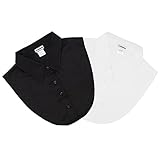

Product Title: 2pack white black womens dickey collars usabased igotcollared aka dicky collar detachable fake blouse collar 
Euclidean Distance from input image: 28.264143
Amazon Url: www.amazon.com/dp/B01N4GCBUM


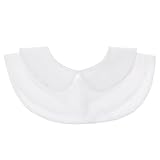

Product Title: kloud city womens turtle neck fake collar detachable shirt dickey blouse false collar white 
Euclidean Distance from input image: 37.13486
Amazon Url: www.amazon.com/dp/B01N7IVVAJ


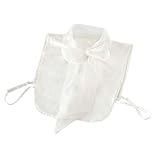

Product Title: joyci fashion main cover organza white bowknot false fake collar office lady dickey 
Euclidean Distance from input image: 37.649506
Amazon Url: www.amazon.com/dp/B019TP6P14


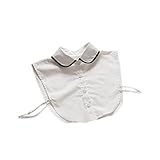

Product Title: joyci womens fashion half shirt blouse dickey simple style false collar 
Euclidean Distance from input image: 37.68003
Amazon Url: www.amazon.com/dp/B0183KXPVE


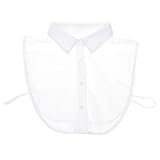

Product Title: kloud city womens half shirt detachable fake collar solid color dickey blouse choker collar white 
Euclidean Distance from input image: 38.057087
Amazon Url: www.amazon.com/dp/B01MU2K4EU


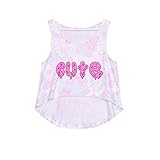

Product Title: 2016 summer crop tops pink cute ice cream print women 
Euclidean Distance from input image: 38.495537
Amazon Url: www.amazon.com/dp/B01ECGCY0Q


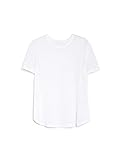

Product Title: alc tesi white linen cross back tee l 
Euclidean Distance from input image: 38.722206
Amazon Url: www.amazon.com/dp/B06ZY8FFRW


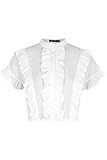

Product Title: boohoo womens petite elsa ruffle short sleeve shirt ivory size 4 
Euclidean Distance from input image: 38.78878
Amazon Url: www.amazon.com/dp/B0757WYDXZ


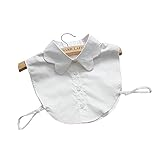

Product Title: joyci winter spring cotton solid creative wave shape womens faux fake collar 
Euclidean Distance from input image: 38.870064
Amazon Url: www.amazon.com/dp/B01ARAKZ3Y


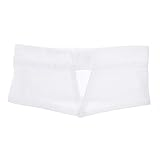

Product Title: kloud city womens short white shirt fake collar cotton detachable dickey blouse choker collar 
Euclidean Distance from input image: 38.908714
Amazon Url: www.amazon.com/dp/B01MZ1OMK9


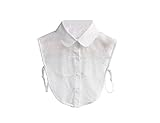

Product Title: elegant fashion white hollowedout lace detachable shirt false collar 
Euclidean Distance from input image: 39.007133
Amazon Url: www.amazon.com/dp/B00NSKF4GY


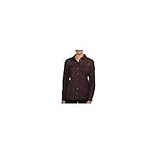

Product Title: jordache womens long sleeve embellished plaid blouse redgreen xxl 
Euclidean Distance from input image: 39.24196
Amazon Url: www.amazon.com/dp/B072284BZP


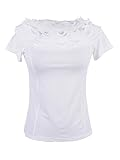

Product Title: annakaci sm fit white wrap around tiered ruffle trim bodice shoulders top 
Euclidean Distance from input image: 39.333794
Amazon Url: www.amazon.com/dp/B00LMKGFS8


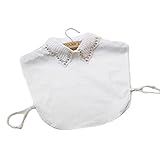

Product Title: qingsun womens fake doll collar vintage elegant beads half shirt blouse detachable false collar white 
Euclidean Distance from input image: 39.743496
Amazon Url: www.amazon.com/dp/B06X988B4Q


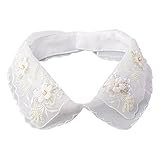

Product Title: detachable false collar neckband stylish shirt collar fake collar stand collar no01 
Euclidean Distance from input image: 39.863003
Amazon Url: www.amazon.com/dp/B01N5HZT1V
------------------------------------------------------------------------------------------------------------------------
Average euclidean dist : 37.98402086893717


In [80]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import display, Image

# Load features and corresponding ASINS info
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy').tolist()

# Load the original 16K dataset
data = pd.read_pickle('pickles/16k_apparel_data_preprocessed')
df_asins = list(data['asin'])

def strip_prefix(asin):
    # Remove 'ages_cnn\\' prefix if present
    if asin.startswith('ages_cnn\\'):
        return asin[len('ages_cnn\\'):]
    return asin

# Strip the prefix from each ASIN in asins
asins = [strip_prefix(asin) for asin in asins]

def get_similar_products_cnn(doc_id, num_results):
    if doc_id >= len(df_asins):
        print("Invalid doc_id:", doc_id)
        return

    target_asin = df_asins[doc_id]
    if target_asin not in asins:
        print(f"ASIN '{target_asin}' (stripped) is not found in the 'asins' list.")
        return

    asin_id = asins.index(target_asin)
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[asin_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[1:num_results + 1]  # Exclude the first index (self-distance)
    pdists = np.sort(pairwise_dist.flatten())[1:num_results + 1]

    for i in range(len(indices)):
        target_asin_index = indices[i]
        selected_rows = data[data['asin'] == asins[target_asin_index]][['medium_image_url', 'title']]

        for indx, row in selected_rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title:', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amazon.com/dp/' + asins[target_asin_index])
    print("-"*120)
    print(f"Average euclidean dist : {sum(pdists) / len(pdists)}")

get_similar_products_cnn(105, 15)

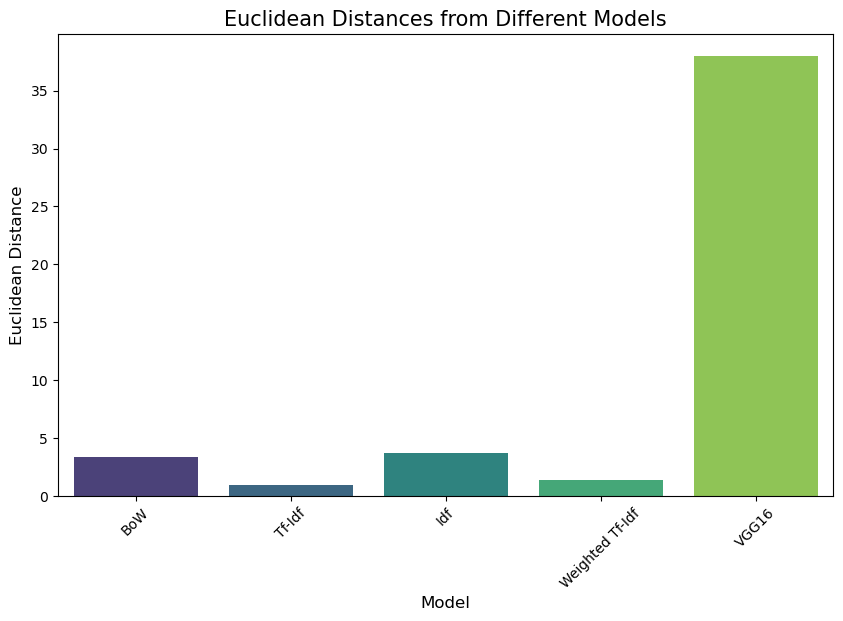

In [81]:

results = {
    'Model': ['BoW', 'Tf-Idf', 'Idf', 'Weighted Tf-Idf', 'VGG16'],
    'Euclidean Distance': [3.3691305148003954, 0.9666054519658698, 3.7416573867739413, 1.4212889258932686, 37.98402086893717]
}
df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Euclidean Distance', data=df, palette='viridis')
plt.title('Euclidean Distances from Different Models', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()